In [37]:
import math 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import quaternion as Quaternion
from matplotlib.ticker import ScalarFormatter

import pca

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import decimate, resample_poly, resample
from scipy.interpolate import PchipInterpolator

from ahrs.filters.madgwick import Madgwick #ahrs library requires git clone, do not pip install


In [38]:

xl1 = pd.read_csv("imu_raw/xl1.csv")
xl2 = pd.read_csv("imu_raw/xl2.csv")
xl3 = pd.read_csv("imu_raw/xl3.csv")

mg1 = pd.read_csv("imu_raw/mg1.csv")
mg2 = pd.read_csv("imu_raw/mg2.csv")
gy = pd.read_csv("imu_raw/gy.csv")

#collect first 1000 intervals
xl1_group = xl1.groupby('interval')
first_10_xl = [group[['interval','timestamp','xl1.x','xl1.y','xl1.z']] for i, (name,group) in enumerate(xl1_group) if i < 1000]
xl_dat = pd.concat(first_10_xl).values

mg1_group = mg1.groupby('interval')
first_10_mg = [group[['interval','timestamp','mg1.x','mg1.y','mg1.z']] for i, (name,group) in enumerate(mg1_group) if i < 1000]
mg_dat = pd.concat(first_10_mg).values

gy_group = gy.groupby('interval')
first_10_gy = [group[['interval','timestamp','gy.x','gy.y','gy.z']] for i, (name,group) in enumerate(gy_group) if i < 1000]
gy_dat = pd.concat(first_10_gy).values

print(gy_dat.shape, mg_dat.shape, xl_dat.shape)

(933740, 5) (18427, 5) (930064, 5)


In [39]:
def gyr_offset_radians(gyr_dat, offset):
    """Put gy data in radians, remove measured error """
    gyr_off = gyr_dat - offset
    gyro_rad = gyr_off * ( np.pi / 180)
    
    return gyro_rad

def microtesla_to_nanotesla(value_µT):
    return value_µT * 1000

def clip_xl(xl_dat, clip):
    """
    XL sensors above certain thresholds are defective
    """
    xl_clipped = np.where(xl_dat > clip, clip, xl_dat)
    xl_clipped = np.where(xl_clipped < -1*clip, -1*clip, xl_clipped)
    return xl_clipped

def correct_data(dat):
    """ 
    Sorts sensor data by timestamp and removes duplicates
    Params: 
        dat: sensor data 
    """
    dat = np.array(dat).astype(float)
    sorted_dat = dat[dat[:,0].argsort()]

    _, unique_indices = np.unique(sorted_dat[:,0], return_index = True)
    processed_data = sorted_dat[unique_indices]
    return processed_data

def preprocess_imu(xl_raw, mag_raw, gyr_raw, gyr_offset = np.array([.58, .42, -.3])):
    """
    correct units, remove gyr offset
    Returns:
        data_matrix: (xl, mag, gyr)
    """
    xl_raw = clip_xl(xl_raw, 2)
    xl = xl_raw * 9.810665
    gyr_offset = gyr_offset # Ahmed: how were these offset values chosen?
    gyr = gyr_offset_radians(gyr_raw, gyr_offset)
    mag = microtesla_to_nanotesla(mag_raw)
    return xl, mag, gyr

In [40]:

def quatConjucate(q):
        w,x,y,z = q
        q_star = np.array([w,-x,-y,-z])
        return q_star
        
def quatProduct(q, p):
        q = np.array(q)
        p = np.array(p)
        w, x, y, z = list(q)

        q_matrix = np.array([
            [w, -x, -y, -z],
            [x, w, -z, y],
            [y, z, w, -x],
            [z, -y, x, w]
        ])
        return q_matrix @ p

def inverse(q):
    q_star = quatConjucate(q)
    mag =  np.sqrt(np.sum(np.square(q)))
    if  0.998 < mag < 1.001:
        return q_star
    else:
        q_inverse = q_star / mag**2
        return q_inverse
      

def rotate_vector(q, v, active=True):
        v = np.insert(np.array(v), 0, 0)  # convert to pure quaternion
        q_inv = inverse(q)
        if active: # object rotation
            q_product = quatProduct(q, v)
            q_rot = quatProduct(q_product, q_inv)
        else: # coordinate rotation
            q_product = quatProduct(q_inv, v)
            q_rot = quatProduct(q_product, q)

        return q_rot[1:]

def R(q_w, q_x, q_y, q_z):
    """
    Direction Cosine Matrix to rotate between two frames
    """
    # rotation_matrix = np.array([
    #     [q_w**2+q_x**2-q_y**2-q_z**2, 2*(q_x*q_y-q_w*q_z), 2*(q_x*q_z+q_w*q_y)],
    #     [2*(q_x*q_y+q_w*q_z), q_w**2-q_x**2+q_y**2-q_z**2, 2*(q_y*q_z-q_w*q_x)],
    #     [2*(q_x*q_z-q_w*q_y), 2*(q_w*q_x+q_y*q_z), q_w**2-q_x**2-q_y**2+q_z**2]
    # ])
            
    rotation_matrix = np.array([
        [1.0-2.0*(q_y**2+q_z**2), 2.0*(q_x*q_y-q_w*q_z), 2.0*(q_x*q_z+q_w*q_y)],
        [2.0*(q_x*q_y+q_w*q_z), 1.0-2.0*(q_x**2+q_z**2), 2.0*(q_y*q_z-q_w*q_x)],
        [2.0*(q_x*q_z-q_w*q_y), 2.0*(q_w*q_x+q_y*q_z), 1.0-2.0*(q_x**2+q_y**2)]
        ])
    return rotation_matrix

def rotate_to_ned(q, vec, madg):
    """
    rotates raw data by quaternion into global frame
    # """
    if (madg == True):
        rotation_matrix = R(*q) 
        global_estimate = rotation_matrix.T @ vec 
    else:
        global_estimate = rotate_vector(q, vec, active=False)

    return global_estimate


In [41]:
def interpolate_points(dat_ned, timestamps, odr):
    
    X_interpolate = np.arange(odr)
    interpolated_data = []

    for ax in range(3):
        spline = PchipInterpolator(timestamps, dat_ned[:,ax])
        interolated_points = spline(X_interpolate)

        interpolated_data.append(interolated_points)
    return np.array(interpolated_data).T

def time_align(xyz, sensor_odr, interval_odr, name):
    """ 
    Upsample data 2x interval odr(fourier signal), decimate data back down(lowpass filter), interpolate to desired interval odr, select current interval points
    """
    xyz_w = []
    len_w = []
    for i, itvl in enumerate(xyz):
        xyz_w.append(itvl)
        len_w.append(len(itvl))

    xyz_w = np.vstack(xyz_w)

    #resample/decimate/interpolate for entire window 
    xyz_r = resample(xyz_w, num=(sensor_odr*len(len_w))*2, axis=0) # set upsample 2x odr
    # print('xyz_r', xyz_r.shape)

    factor = xyz_r.shape[0]//((sensor_odr*len(len_w))) #set to downsample back to sensor odr
    xyz_d = decimate(xyz_r, q=factor, axis=0)
    # print('xyz_d', xyz_d.shape)
    
    new_points = interpolate_points(xyz_d, np.arange(xyz_d.shape[0]), interval_odr*3)
    current_points = new_points[interval_odr:interval_odr*2] #assumes window size 3 here 
    
    return np.array(current_points)

In [42]:
def imu_processing(xl, mg, gy, interval_odr, madg = True):
    """
    Main function, group data by intervals, build window of adjacent intervals for time alignment, this fixes errors on ends from resampling and decimating
    """

    sensor_odr = {"xl":1000, 'gy':1000, 'mg':20}
    sensor_dt = {'xl':.001, 'gy':.001, 'mg':.05}

    cols =['interval','timestamp','x', 'y', 'z']
    xl_df = pd.DataFrame(xl, columns=cols)
    mg_df = pd.DataFrame(mg, columns=cols)
    gy_df = pd.DataFrame(gy, columns=cols)

    xl_group = xl_df.groupby('interval')
    mg_group = mg_df.groupby('interval')
    gy_group = gy_df.groupby('interval')

    # print(list(xl_group))

    xl_global = []
    prev_q = [1,0,0,0]

    xl_w = [] #(3, n, 3) => window size 3, n points, xyz axis
    gy_w = []
    mg_w = []

    for (name1, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):

        xl_ = correct_data(xl_grp.drop(columns=['interval']).values)
        mg_ = correct_data(mg_grp.drop(columns=['interval']).values)
        gy_ = correct_data(gy_grp.drop(columns=['interval']).values)
        xl_p, mg_p, gy_p = preprocess_imu(xl_[:,1:], mg_[:,1:], gy_[:,1:])

        xl_w.append(xl_p)
        mg_w.append(mg_p)
        gy_w.append(gy_p)

        if len(xl_w) > 3: #build window  
            xl_w.pop(0)
            mg_w.pop(0)
            gy_w.pop(0)
    
        if len(xl_w) != 3:
            continue 
        
        xl_t = time_align(xl_w, 1000, interval_odr, 'xl')
        mg_t = time_align(mg_w, 20, interval_odr, 'mg')
        gy_t = time_align(gy_w, 1000, interval_odr, 'gy')

        #Madgwick model gives quaternion vectors that rotate xl vector from sensor to ned frame
        model = Madgwick(acc=xl_t, mag=mg_t, gyr=gy_t, frequency=interval_odr, q0 = prev_q)
        prev_q = model.Q[-1]

        for q,x in zip(model.Q, xl_t):
            mag = np.linalg.norm(x)
            norm_vec = x / mag
            ned_vec = rotate_to_ned(q, norm_vec, madg)
            ned_vec *= mag
            ned_vec[2] -= 9.810665 #in ned frame, assume z axis aligns with gravity, subtract it off
            xl_global.append(ned_vec)
        
    return xl_global


In [43]:
xl_ned = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100))
print(np.array(xl_ned).shape)

(99800, 3)


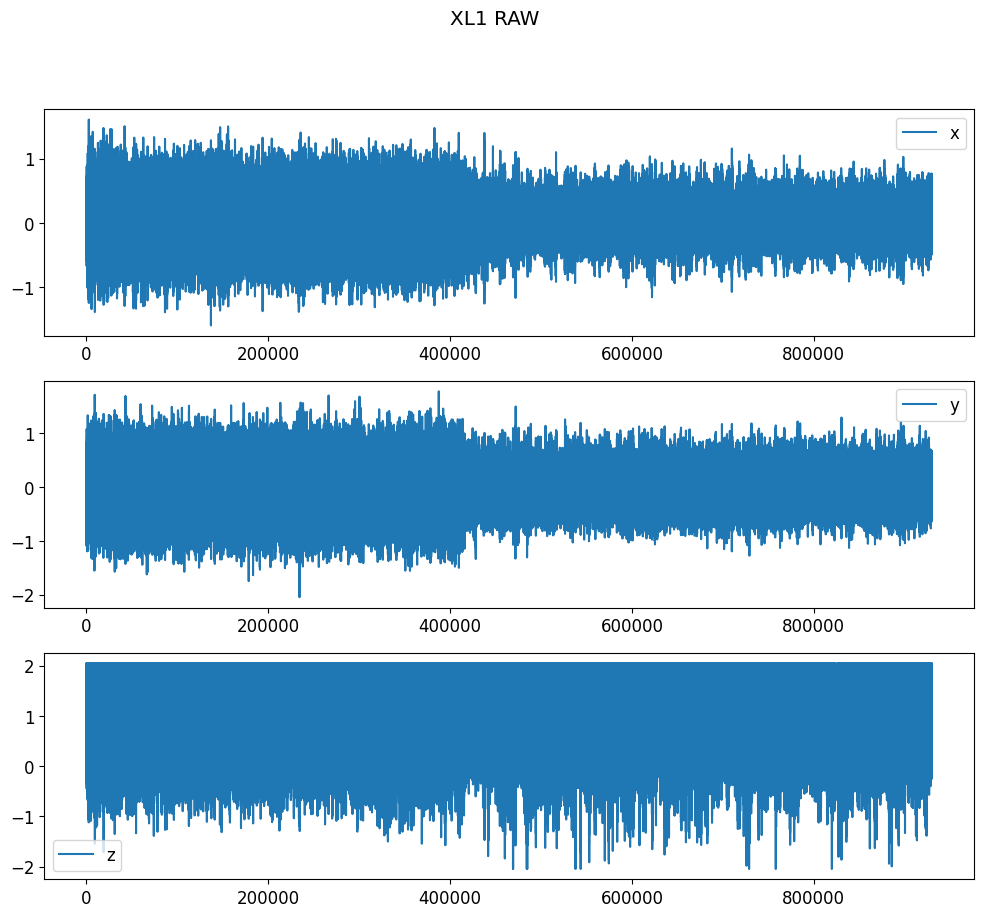

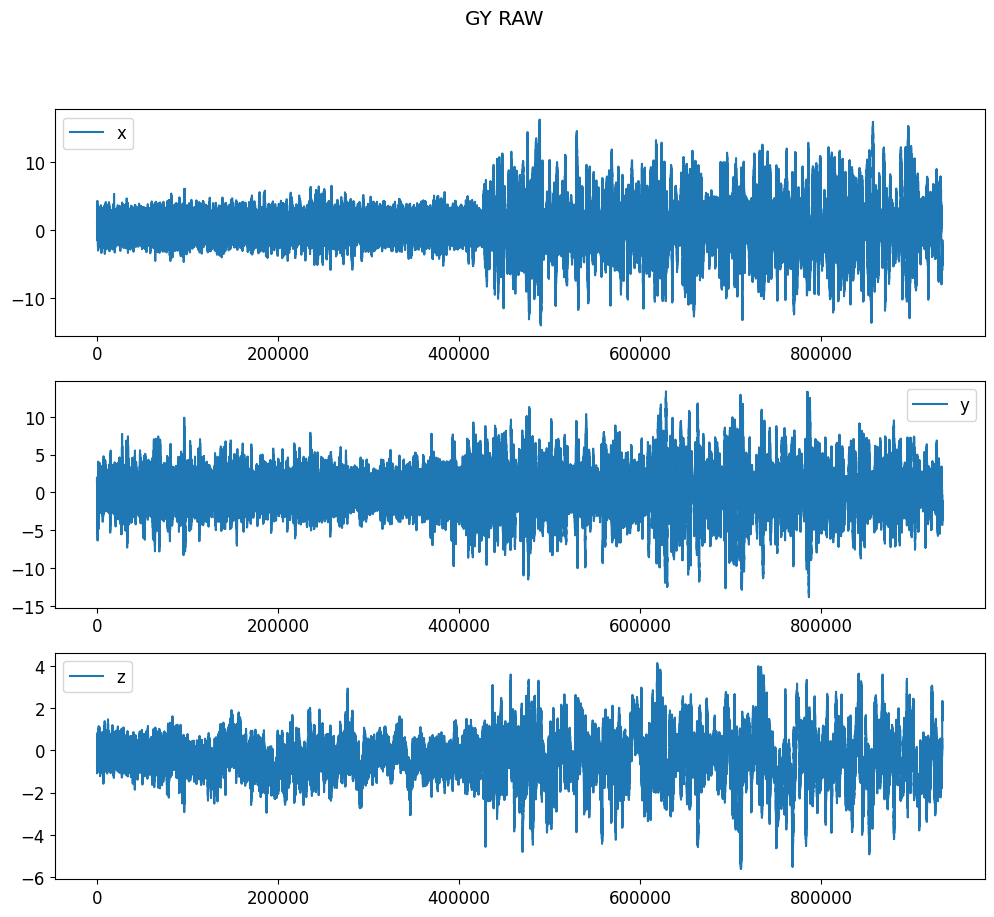

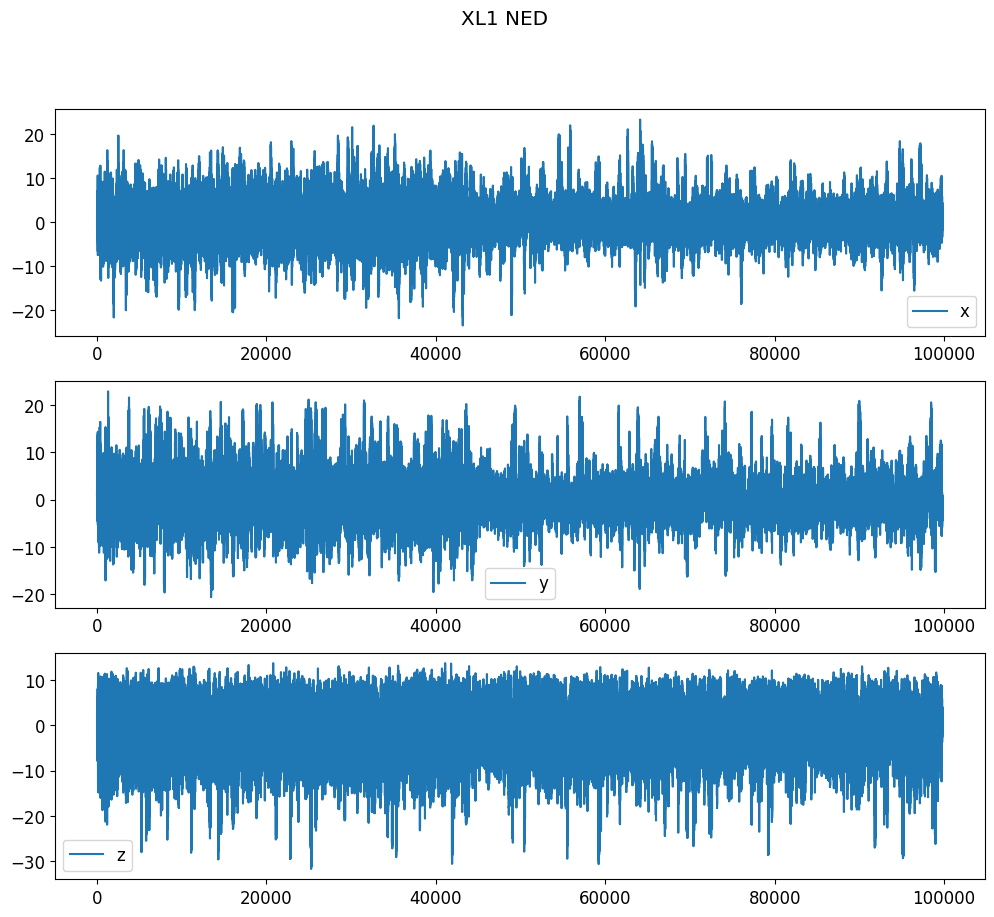

In [44]:
fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_dat[:,2], label='x') #(interval, timestamp, x,y,z)
axes[1].plot(xl_dat[:,3], label='y')
axes[2].plot(xl_dat[:,4], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 RAW')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(gy_dat[:,2], label='x')#(interval, timestamp, x,y,z)
axes[1].plot(gy_dat[:,3], label='y')
axes[2].plot(gy_dat[:,4], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('GY RAW')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned[:,0], label='x')
axes[1].plot(xl_ned[:,1], label='y')
axes[2].plot(xl_ned[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 NED')
plt.show()

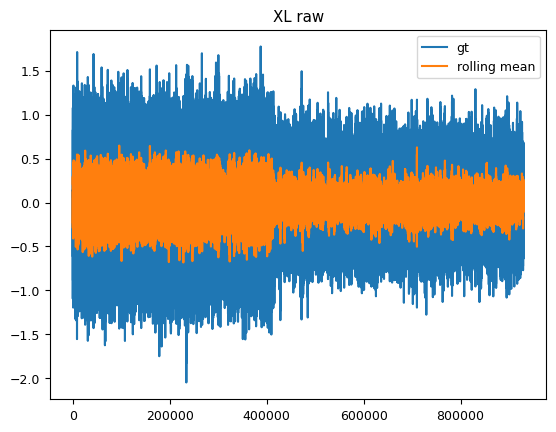

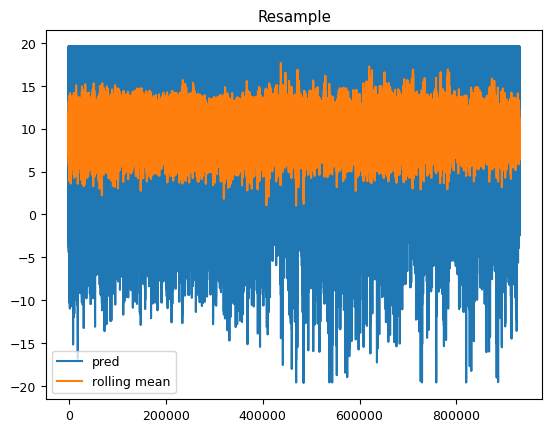

C:\Users\ChoudhryAhmed\AppData\Local\Temp\ipykernel_11256\3606981718.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


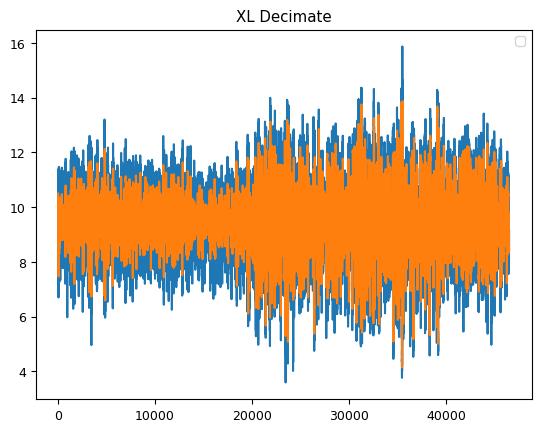

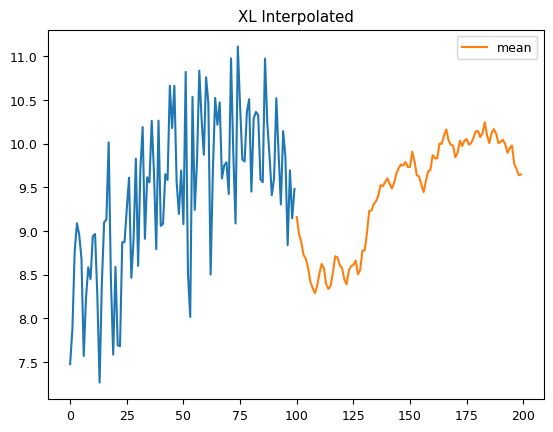

[3.4255787382188974, 3.442200551475739, 3.44965605778517, 3.4527380006194517, 3.4542654815083806, 3.4551254809076535, 3.4556546565777913, 3.4560028534471043, 3.456243537771085, 3.4564167088061764]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[[3.9401952314011375, 4.727060783754079, 4.386568981492892, 4.21551606020661, 4.388205628053257, 4.343535204643161, 4.351167635677766, 4.4722981783317275, 4.619971109707533, 4.290150948930207, 3.9913611154954887, 4.085113978931611, 3.969608361853871, 4.277358651716196, 3.965275555014029, 4.167862619910155, 3.6950597104499647, 4.646669402200438, 4.514124872408555, 4.277019849688096, 4.304291702420849, 3.9089755367592267, 4.0737480065716465, 4.083632871469059, 3.823965107256125, 4.0676027564096495, 4.092953727009607, 3.76364858012084, 4.014223415438168, 4.233348059893756, 3.739881810254934, 4.287516623003412, 4.273018704639458, 4.060662987283319, 4.223828650433217, 4.125741068306293, 3.927978986005923, 4.187640555173215, 4.063056822954873, 4.1

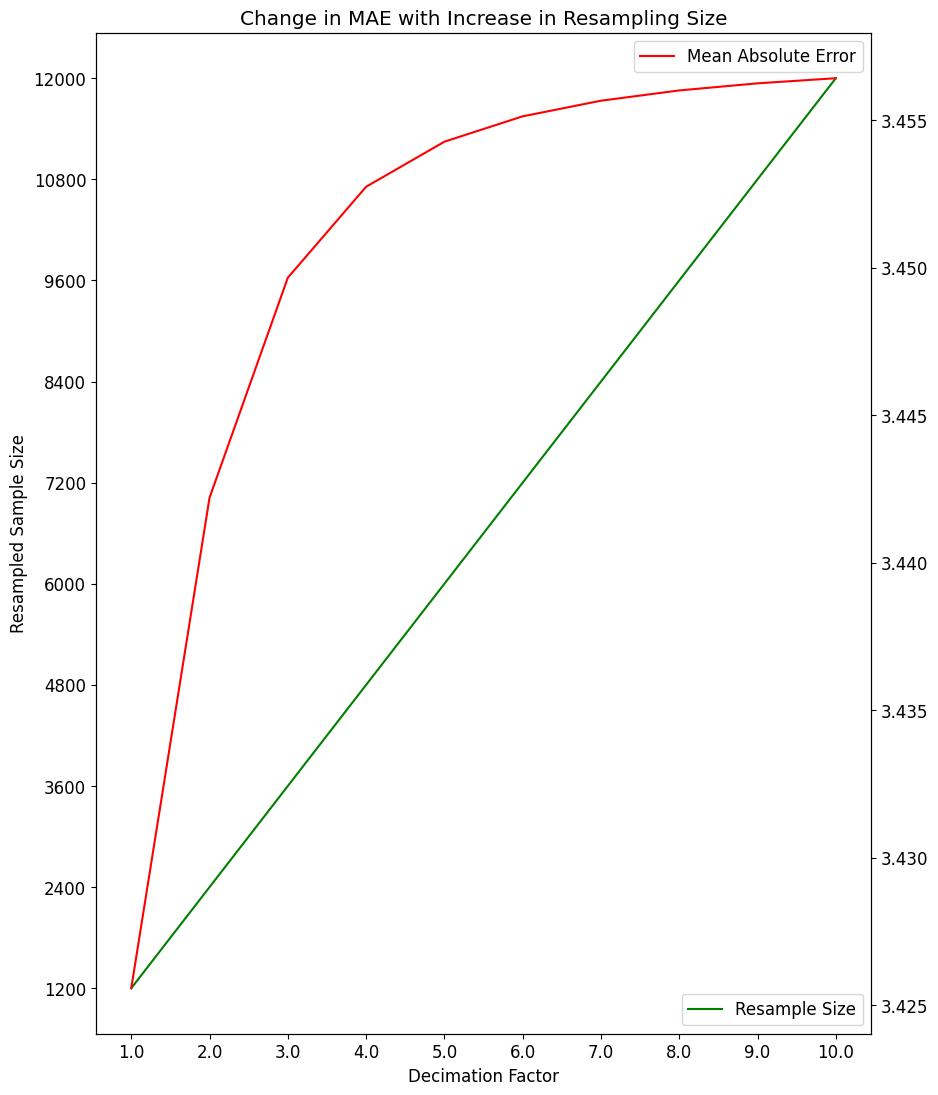

In [45]:
plt.rcParams.update({'font.size': 9})

def keep_every_k_of_n(arr, k, n,):
    """
    Keeps `k` elements for every `n` elements from the array, simulate missing data 
    """
    kept = []
    i = 0
    while i < len(arr):
        kept.extend(arr[i:i+k])
        i += n
    return kept

# xl_missing = np.array(keep_every_k_of_n(xl_dat[:1000,:], 400, 500))
# print(np.array(xl_missing).shape)

#helper functions for experimenting with different parameters, plot rolling means  
xl_ = correct_data(xl_dat[:,1:])
xl_ = clip_xl(xl_, 2)
xl_ *= 9.8
xl_resample = resample(xl_[:,3], num=930064)
xl_decimate = decimate(xl_resample, q=20)

#raw data
rolling_mean = pd.Series(xl_dat[:,3]).rolling(window=10).mean()
plt.plot(xl_dat[:,3], label='gt')
plt.plot(rolling_mean, label='rolling mean')
plt.legend()
plt.title('XL raw')
plt.show()

#xl resample
rolling_mean = pd.Series(xl_resample).rolling(window=10).mean()
plt.plot(xl_resample, label='pred')
plt.plot(rolling_mean, label='rolling mean')
plt.title('Resample')
plt.legend()
plt.show()

#xl decimate
rolling_mean = pd.Series(xl_decimate).rolling(window=10).mean()
plt.plot(xl_decimate)
plt.plot(rolling_mean)
plt.title('XL Decimate')
plt.legend()
plt.show()

spline = PchipInterpolator(np.arange(xl_decimate.shape[0]), xl_decimate)
interpolated_points = spline(np.arange(0, 930064, 1))

rolling_mean = pd.Series(interpolated_points[:300]).rolling(window=10).mean()
plt.plot(interpolated_points[100:200])
plt.plot(rolling_mean[100:200], label='mean')
plt.title("XL Interpolated")
plt.legend()
plt.show()

# Resampling and Decimating

cols =['interval','timestamp','x', 'y', 'z']
xl_df = pd.DataFrame(xl_dat, columns=cols)
mg_df = pd.DataFrame(mg_dat, columns=cols)
gy_df = pd.DataFrame(gy_dat, columns=cols)

xl_group = xl_df.groupby('interval')
mg_group = mg_df.groupby('interval')
gy_group = gy_df.groupby('interval')

resample_sizes = []
mean_squared_list = []
decimate_sizes = []

total_interval_vals =[] # a list of lists of all MSE values per decimation factor

for i in range(1, 11, 1):
    xl_global = []
    xl_w = []
    counter = 0
    total_mse = 0
    check = False
    interval_vals = [] # a list of all MSE values per decimation factor
    for (name, xl_grp), (name, mg_grp), (name, gy_grp) in zip(xl_group, mg_group, gy_group):
        xl_required = correct_data(xl_grp.drop(columns=['interval']).values)
        xl_required = clip_xl(xl_required[:,1:], 2)
        xl_test = xl_required * 9.810665  # ground truth data 

        xl_w.append(xl_test)

        if len(xl_w) > 3: #build window  
            xl_w.pop(0)
    
        if len(xl_w) != 3:
            continue

        new_xl_w = [] # to unpack all 3 intervals for the window
        len_w = []
        for j, itvl in enumerate(xl_w):
            new_xl_w.append(itvl)
            len_w.append(len(itvl)) 
        
        new_xl_w = np.vstack(new_xl_w)

        if (new_xl_w.shape[0] == 3000):
            check = True
            xl_simulate = new_xl_w[1000:2000,:]

            xl_missing = keep_every_k_of_n(xl_simulate, 400, 500) # removes 200 data points for each 1000 point interval
            xl_to_use = np.vstack([new_xl_w[0:1000], xl_missing, new_xl_w[2000:3000]])

            xl_r = resample(xl_to_use, num = 1200*i, axis = 0)
            factor = xl_r.shape[0]/1200
            # factor = round(factor, 2)
            factor_rounded = int(xl_r.shape[0]/1200) # this ensures that data is always downsampled to 1200
            xl_d = decimate(xl_r, q = factor_rounded, axis = 0)  

            interval_mse = mean_absolute_error(np.array(xl_d[100:1100]), new_xl_w[1000:2000,:])
            counter += 1
            total_mse += interval_mse
            
            interval_vals.append(interval_mse)

    if len(xl_w) != 3:
        continue

    if (check == True):
        average_mse = total_mse / counter
        resample_sizes.append(1200*i)
        decimate_sizes.append(factor)

        mean_squared_list.append(average_mse)

        total_interval_vals.append(interval_vals)

print(mean_squared_list)
print(decimate_sizes)
print(total_interval_vals)
print(np.array(total_interval_vals).shape)

plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(13)
ax_t = ax1.twinx()
ax1.plot(decimate_sizes, resample_sizes, label = "Resample Size", c= 'green')
ax_t.plot(decimate_sizes, mean_squared_list, label = "Mean Absolute Error", c="red")
ax1.set_xticks(decimate_sizes, labels=list(decimate_sizes))
ax1.set_yticks(resample_sizes, labels=list(resample_sizes))
ax1.set_xlabel("Decimation Factor")
ax1.set_ylabel("Resampled Sample Size")
ax1.set_title("Change in MAE with Increase in Resampling Size")
ax1.legend(loc = "lower right")
ax_t.legend()
plt.show()

590
590
590
590
590
590
590
590
590
590
[294.7926582200421, 294.9111743702205, 294.90571853426053, 294.9101152129471, 294.9135242230738, 294.91549079458787, 294.91709170132435, 294.91851129342234, 294.92369495779775, 294.92814333015576]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[[238.17637440401117, 215.49346363511123, 265.82921895139253, 209.072830045622, 242.43265195668923, 225.2395465105177, 249.98980174040324, 233.46049519241774, 219.37853707097722, 240.5259184731996, 207.61580150602103, 247.72864082135334, 227.13204040766956, 245.86306695408635, 240.3382194570644, 260.0739828207458, 246.700639426434, 217.6127790961492, 279.7446888555316, 234.30775335411866, 285.17872400658774, 223.88580455679667, 250.79836705842993, 243.39769022986778, 222.49708790572365, 226.74300373828783, 237.53438194641373, 226.6377132867176, 247.67637991081358, 233.2784458075199, 226.03477766001765, 251.75023670278043, 231.55038793209485, 296.71700627340823, 222.3708501532018, 288.83556063859083, 28

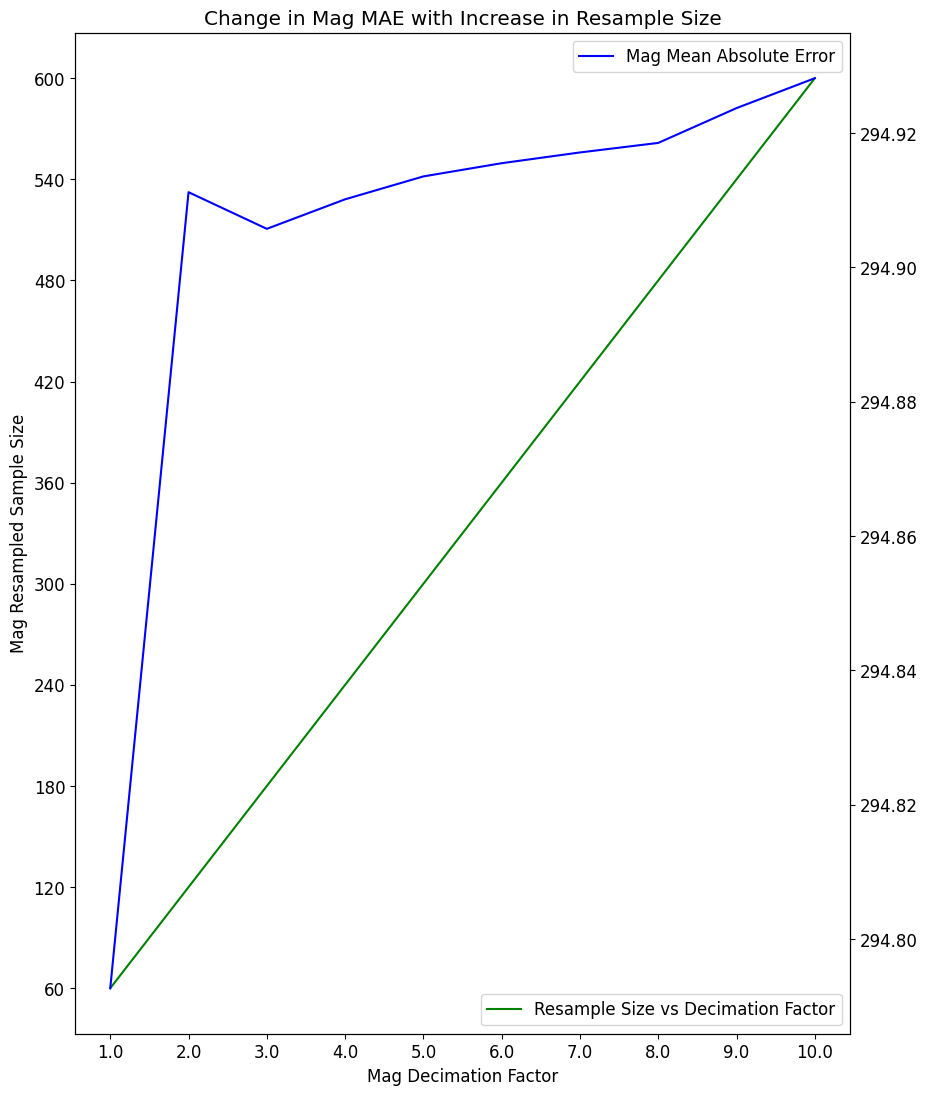

In [46]:
# Resampling and Decimating Magnetometer Data

plt.rcParams.update({'font.size': 12})
mag_resample_sizes = []
mag_mean_squared_list = []
mag_decimate_sizes = []

mag_total_interval_vals = [] # a list of lists of all MSE values per decimation factor
for i in range(1, 11, 1):
    mag_global = []
    mag_w = []
    mag_counter = 0
    mag_total_mse = 0
    mag_check = False
    mag_interval_vals = [] # a list of all MSE values for per decimation factor
    for (name, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):
        mag_required = correct_data(mg_grp.drop(columns=['interval']).values)
        mag_test = microtesla_to_nanotesla(mag_required[:,1:]) 

        mag_w.append(mag_test)

        if len(mag_w) > 3: #build window  
            mag_w.pop(0)
  
        if len(mag_w) != 3:
            continue

        new_mag_w = [] # to unpack all 3 intervals for the window
        mag_len_w = []
        for mag_j, mag_itvl in enumerate(mag_w):
            new_mag_w.append(mag_itvl)
            mag_len_w.append(len(mag_itvl)) 
        
        new_mag_w = np.vstack(new_mag_w)

        if (new_mag_w.shape[0] == 60):
            mag_check = True
            mag_simulate = new_mag_w[20:40]

            mag_missing = keep_every_k_of_n(mag_simulate, 15, 20) # removes 5 data points for each 20 point interval
            mag_to_use = np.vstack([new_mag_w[0:20], mag_missing, new_mag_w[40:60]])

            mag_r = resample(mag_to_use, num = 60*i, axis = 0)
            mag_factor = mag_r.shape[0]/60
            mag_factor = round(mag_factor, 2)
            mag_factor_rounded = int(mag_r.shape[0]/60) # this ensures that data is always downsampled to 60
            mag_d = decimate(mag_r, q = mag_factor_rounded, axis = 0)  

            mag_interval_mse = mean_absolute_error( new_mag_w[20:40,:], np.array(mag_d[20:40]))
            mag_counter += 1
            mag_total_mse += mag_interval_mse
            
            mag_interval_vals.append(mag_interval_mse)

    if len(mag_w) != 3:
        continue

    if (mag_check == True):
        print(mag_counter)
        mag_total_interval_vals.append(mag_interval_vals)
        # mag_average_mse = np.mean(mag_total_mse)
        mag_average_mse = mag_total_mse / mag_counter
        # mag_average_mse = round(mag_average_mse, 4)
        mag_resample_sizes.append(60*i)
        mag_decimate_sizes.append(mag_factor)

        mag_mean_squared_list.append(mag_average_mse)

print(mag_mean_squared_list)
print(mag_decimate_sizes)

print(mag_total_interval_vals)
print(np.array(mag_total_interval_vals).shape)

plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(13)
ax_t = ax1.twinx()
ax1.plot(mag_decimate_sizes, mag_resample_sizes, label = "Resample Size vs Decimation Factor", c = "green")
ax_t.plot(mag_decimate_sizes, mag_mean_squared_list, label="Mag Mean Absolute Error", c="blue")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_t.yaxis.set_major_formatter(formatter)
ax1.set_xticks(mag_decimate_sizes, labels=list(mag_decimate_sizes))
ax1.set_yticks(mag_resample_sizes, labels=list(mag_resample_sizes))
ax1.set_xlabel("Mag Decimation Factor")
ax1.set_ylabel("Mag Resampled Sample Size")
ax1.legend(loc = "lower right")
ax1.set_title("Change in Mag MAE with Increase in Resample Size")
ax_t.legend()
plt.legend()
plt.show()

589
589
589
589
589
589
589
589
589
589
[0.011016878736096388, 0.011010963539238347, 0.011013109666946769, 0.011013717901759281, 0.011013957105832141, 0.011014074375651252, 0.011014140560685465, 0.011014181655944895, 0.01101420896671181, 0.01101422806982687]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[[0.011491874831907785, 0.013949334732438297, 0.012008595165628064, 0.011875091487797695, 0.012096647407097786, 0.013032898240050309, 0.013248042771293085, 0.013542039318743503, 0.013589633295604824, 0.014067182419478325, 0.010830734017837067, 0.012065264017287044, 0.011685817202094545, 0.01274048865174676, 0.01144169301613396, 0.012633001388541072, 0.00983874963316613, 0.01323116559969994, 0.013266794694343343, 0.01276574518006012, 0.013248077903252562, 0.0101143292338406, 0.011287831114435926, 0.0110036829479003, 0.011579636169531247, 0.011270590923818472, 0.013485596224421225, 0.011087477544584633, 0.01157021892041811, 0.012372179782249887, 0.010209871924757785, 0.0122086792395

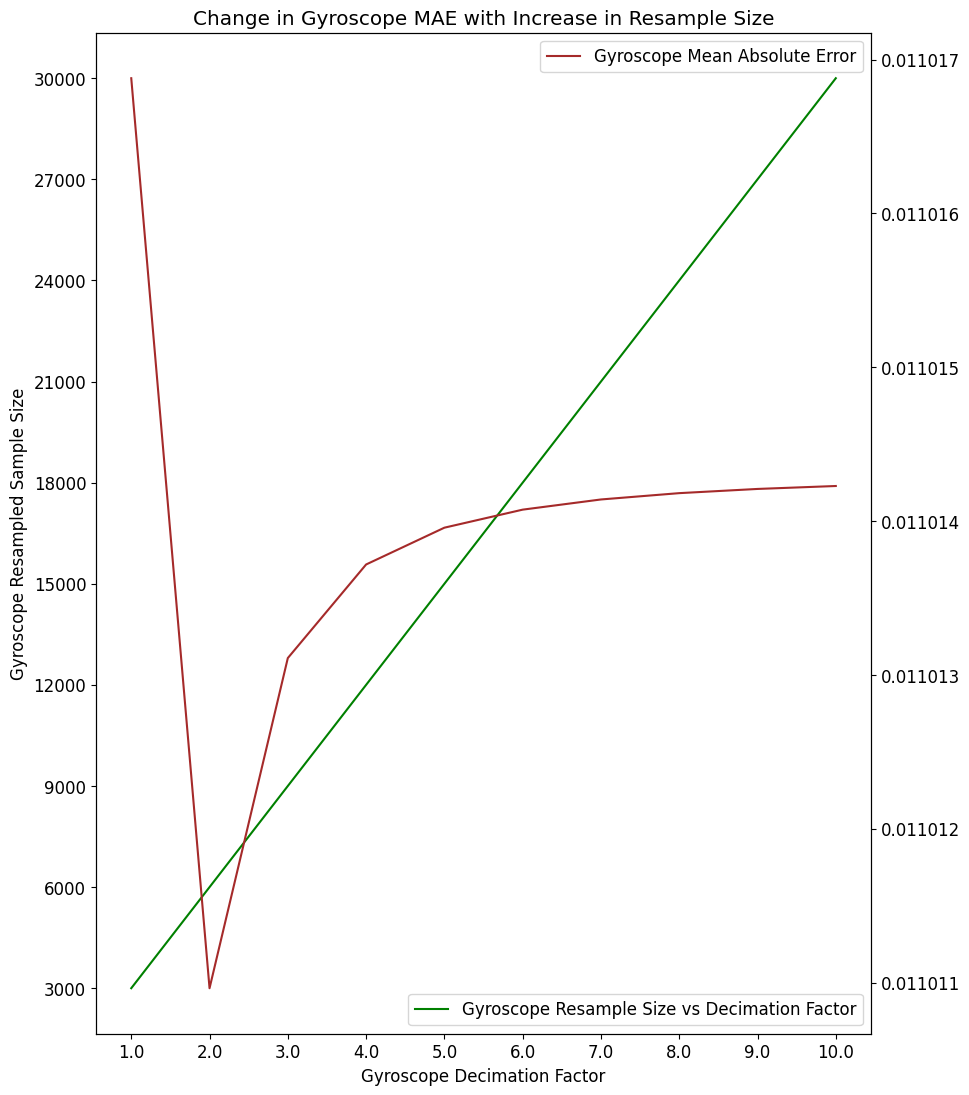

In [47]:
# Resampling and Decimating Gyroscope Data

plt.rcParams.update({'font.size': 12})
gy_resample_sizes = []
gy_mean_squared_list = []
gy_decimate_sizes = []

gy_total_interval_vals = [] # a list of lists of all MSE values per decimation factor
for i in range(1, 11, 1):
    gy_global = []
    gy_w = []
    gy_counter = 0
    gy_total_mse = 0
    gy_check = False
    gy_interval_vals = [] # a list of all MSE values for per decimation factor
    for (name, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):
        gy_required = correct_data(gy_grp.drop(columns=['interval']).values)
        gy_test = gyr_offset_radians(gy_required[:,1:], np.array([.58, .42, -.3]))

        gy_w.append(gy_test)

        if len(gy_w) > 3: #build window  
            gy_w.pop(0)
  
        if len(gy_w) != 3:
            continue

        new_gy_w = [] # to unpack all 3 intervals for the window
        gy_len_w = []
        for gy_j, gy_itvl in enumerate(gy_w):
            new_gy_w.append(gy_itvl)
            gy_len_w.append(len(gy_itvl)) 
        
        new_gy_w = np.vstack(new_gy_w)

        if (new_gy_w.shape[0] == 3000):
            gy_check = True
            gy_simulate = new_gy_w[1000:2000]

            gy_missing = keep_every_k_of_n(gy_simulate, 400, 500) # removes 200 data points for each 1000 point interval
            gy_to_use = np.vstack([new_gy_w[0:1000], gy_missing, new_gy_w[2000:3000]])

            gy_r = resample(gy_to_use, num = 3000*i, axis = 0)
            gy_factor = gy_r.shape[0]/3000
            gy_factor = round(gy_factor, 2)
            gy_factor_rounded = int(gy_r.shape[0]/3000) # this ensures that data is always downsampled to 3000
            gy_d = decimate(gy_r, q = gy_factor_rounded, axis = 0)  

            gy_interval_mse = mean_absolute_error( new_gy_w[1000:2000,:], np.array(gy_d[1000:2000]))
            gy_counter += 1
            gy_total_mse += gy_interval_mse
            
            gy_interval_vals.append(gy_interval_mse)

    if len(gy_w) != 3:
        continue

    if (gy_check == True):
        print(gy_counter)
        gy_total_interval_vals.append(gy_interval_vals)
        gy_average_mse = gy_total_mse / gy_counter
        gy_resample_sizes.append(3000*i)
        gy_decimate_sizes.append(gy_factor)

        gy_mean_squared_list.append(gy_average_mse)

print(gy_mean_squared_list)
print(gy_decimate_sizes)

print(gy_total_interval_vals)
print(np.array(gy_total_interval_vals).shape)

plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(13)
ax_t = ax1.twinx()
ax1.plot(gy_decimate_sizes, gy_resample_sizes, label = "Gyroscope Resample Size vs Decimation Factor", c = "green")
ax_t.plot(gy_decimate_sizes, gy_mean_squared_list, label="Gyroscope Mean Absolute Error", c="brown")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_t.yaxis.set_major_formatter(formatter)
ax1.set_xticks(gy_decimate_sizes, labels=list(gy_decimate_sizes))
ax1.set_yticks(gy_resample_sizes, labels=list(gy_resample_sizes))
ax1.set_xlabel("Gyroscope Decimation Factor")
ax1.set_ylabel("Gyroscope Resampled Sample Size")
ax1.legend(loc = "lower right")
ax1.set_title("Change in Gyroscope MAE with Increase in Resample Size")
ax_t.legend()
plt.legend()
plt.show()

Total Variance of MAE for Accelerometer
8.559675167480198e-05
---------------------------
Total Variance of MAE for Magnetometer
0.0014062820567353799
---------------------------
Total Variance of MAE for Gyroscope
1.8506201066498484e-12
---------------------------
Individual MAE Standard Deviation List
[np.float64(0.6436686688513023), np.float64(0.6488638150353342), np.float64(0.6505143881878748), np.float64(0.6510694920734554), np.float64(0.6513164144114708), np.float64(0.6514464918158966), np.float64(0.6515233904238941), np.float64(0.6515728110197826), np.float64(0.6516062474213804), np.float64(0.6516300263131211)]
---------------------------


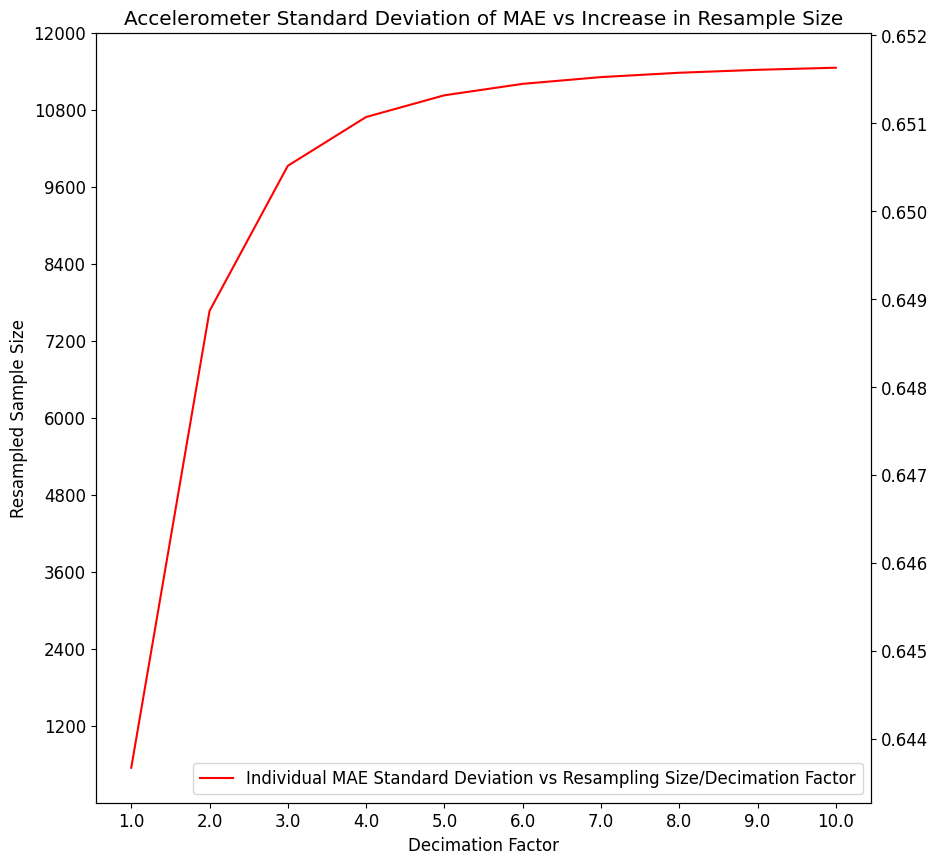

Magnetometer Individual MAE Standard Deviation List
[np.float64(76.99665408010975), np.float64(77.12870632745297), np.float64(77.13264985645536), np.float64(77.14101369778498), np.float64(77.146179689432), np.float64(77.14893652455639), np.float64(77.15084021277971), np.float64(77.1525501098232), np.float64(77.15845650322242), np.float64(77.16367244169288)]
---------------------------


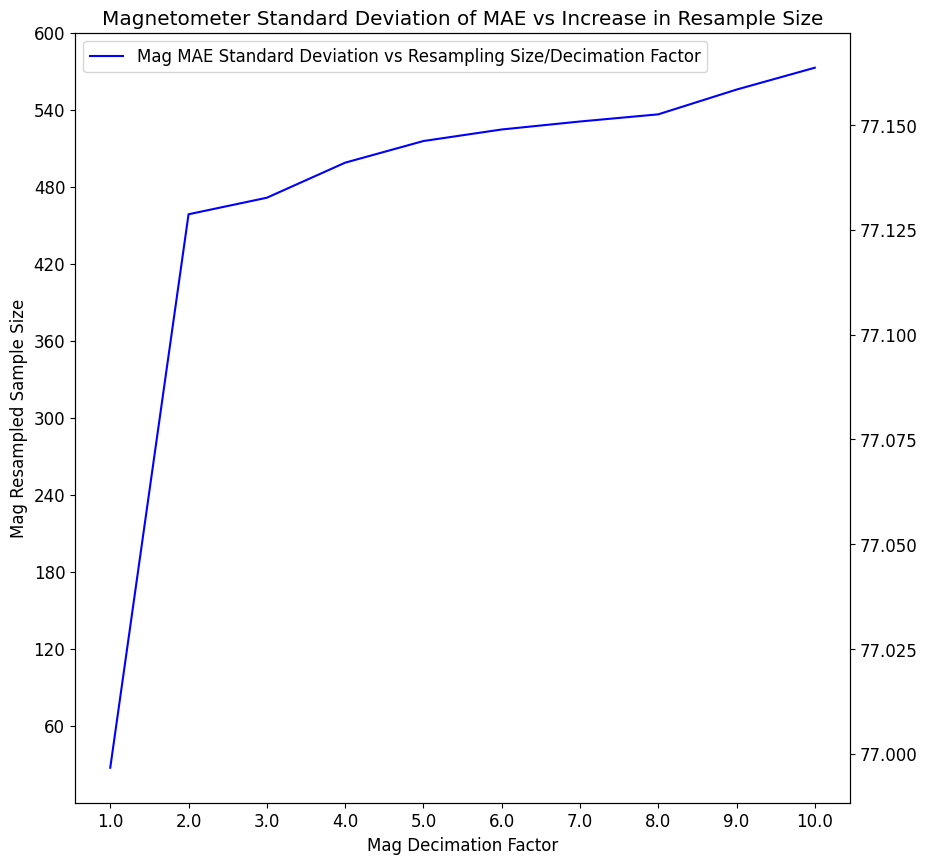

Gyroscope Individual MAE Standard Deviation List
[np.float64(0.0018748899027328687), np.float64(0.00187502785447516), np.float64(0.0018751839371261162), np.float64(0.0018752055452476311), np.float64(0.0018752082049231854), np.float64(0.001875207647478418), np.float64(0.0018752065982872458), np.float64(0.0018752056297485628), np.float64(0.001875204838229329), np.float64(0.00187520420596832)]
---------------------------


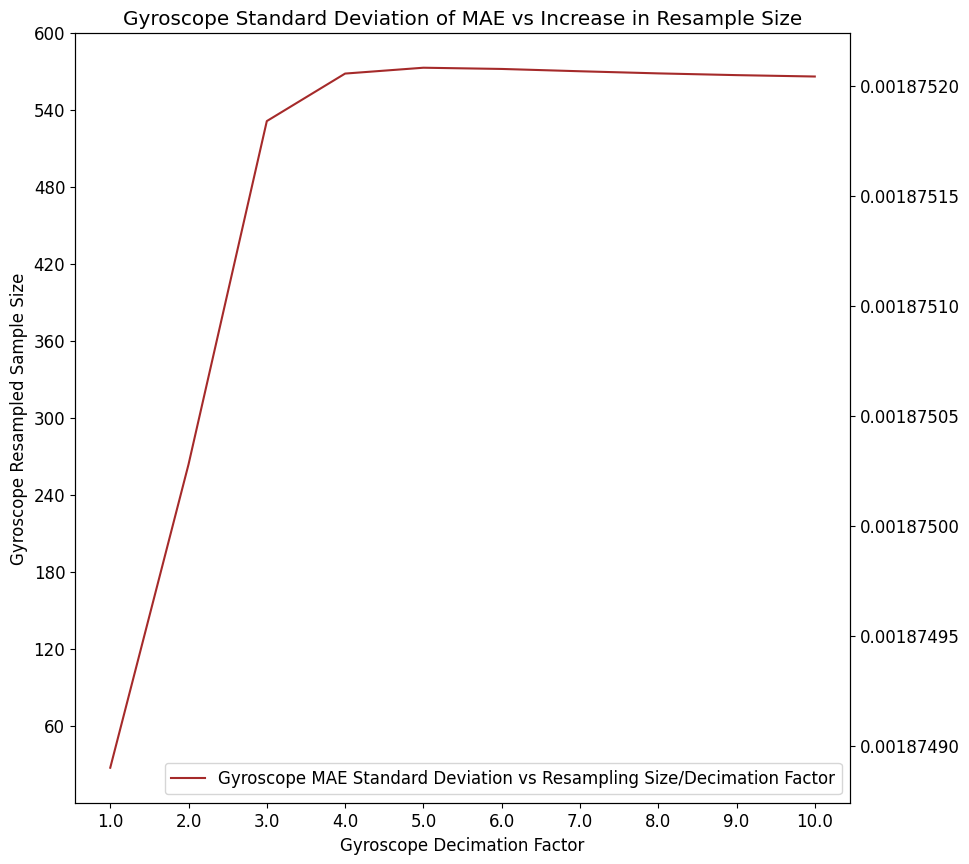

Accelerometer Standard Deviation Average:
0.6503211745553512
---------------------------
Magnetometer Standard Deviaion Average:
77.13196594433096
---------------------------
Gyroscope Variance Average:
0.0018751544364216835


In [48]:
# Calculating Total MAE Variance/Standard Deviation

mse_variance_xl = np.var(mean_squared_list)
print("Total Variance of MAE for Accelerometer")
print(mse_variance_xl)
print("---------------------------")

mse_variance_mag = np.var(mag_mean_squared_list)
print("Total Variance of MAE for Magnetometer")
print(mse_variance_mag)
print("---------------------------")

mse_variance_gy = np.var(gy_mean_squared_list)
print("Total Variance of MAE for Gyroscope")
print(mse_variance_gy)
print("---------------------------")

#  Calculating Individual MAE Variance/Standard Deviation for Accelerometer
variance_list = []
for interval in total_interval_vals:
    interval_var = np.std(interval)
    variance_list.append(interval_var)

print("Individual MAE Standard Deviation List")
print(variance_list)
print("---------------------------")
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax_t = ax1.twinx()
ax_t.plot(decimate_sizes, variance_list, label="Individual MAE Standard Deviation vs Resampling Size/Decimation Factor", c="red")
ax1.set_xticks(decimate_sizes, labels=list(decimate_sizes))
ax1.set_yticks(resample_sizes, labels=list(resample_sizes))
ax1.set_xlabel("Decimation Factor")
ax1.set_ylabel("Resampled Sample Size")
ax1.set_title("Accelerometer Standard Deviation of MAE vs Increase in Resample Size")
plt.legend()
plt.show()

#  Calculating Individual MAE Variance/Standard Deviation for Magnetometer
mag_variance_list = []
for mag_interval in mag_total_interval_vals:
    mag_interval_var = np.std(mag_interval)
    mag_variance_list.append(mag_interval_var)
    
print("Magnetometer Individual MAE Standard Deviation List")
print(mag_variance_list)
print("---------------------------")
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax_t = ax1.twinx()
ax_t.plot(mag_decimate_sizes, mag_variance_list, label="Mag MAE Standard Deviation vs Resampling Size/Decimation Factor", c="blue")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_t.yaxis.set_major_formatter(formatter)
ax1.set_xticks(mag_decimate_sizes, labels=list(mag_decimate_sizes))
ax1.set_yticks(mag_resample_sizes, labels=list(mag_resample_sizes))
ax1.set_xlabel("Mag Decimation Factor")
ax1.set_ylabel("Mag Resampled Sample Size")
ax1.set_title("Magnetometer Standard Deviation of MAE vs Increase in Resample Size")
plt.legend()
plt.show()

#  Calculating Individual MAE Variance/Standard Deviation for Gyroscope
gy_variance_list = []
for gy_interval in gy_total_interval_vals:
    gy_interval_var = np.std(gy_interval)
    gy_variance_list.append(gy_interval_var)
    
print("Gyroscope Individual MAE Standard Deviation List")
print(gy_variance_list)
print("---------------------------")
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax_t = ax1.twinx()
ax_t.plot(gy_decimate_sizes, gy_variance_list, label="Gyroscope MAE Standard Deviation vs Resampling Size/Decimation Factor", c="brown")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_t.yaxis.set_major_formatter(formatter)
ax1.set_xticks(gy_decimate_sizes, labels=list(gy_decimate_sizes))
ax1.set_yticks(gy_resample_sizes, labels=list(mag_resample_sizes))
ax1.set_xlabel("Gyroscope Decimation Factor")
ax1.set_ylabel("Gyroscope Resampled Sample Size")
ax1.set_title("Gyroscope Standard Deviation of MAE vs Increase in Resample Size")
plt.legend()
plt.show()


# Average of Accelerometer Variance List
xl_var_avg = np.average(variance_list)
print("Accelerometer Standard Deviation Average:")
print(xl_var_avg)
print("---------------------------")

# Average of Magnetometer Variance List
mag_var_avg = np.average(mag_variance_list)
print("Magnetometer Standard Deviaion Average:")
print(mag_var_avg)
print("---------------------------")

# Average of Gyroscope Variance List
gy_var_avg = np.average(gy_variance_list)
print("Gyroscope Variance Average:")
print(gy_var_avg)


In [49]:
# Deducing errors due to Resampling and Decimating on Analysis

len_w = 3000
print(np.array(total_interval_vals).shape)
print(np.array(mag_total_interval_vals).shape)
print(np.array(gy_total_interval_vals).shape)


(10, 582)
(10, 590)
(10, 589)


590
[237.91008395837176, 215.26077967352168, 266.0456635725015, 208.28774437671984, 242.55560817792966, 225.47286848516103, 249.8281586035586, 233.61756595215573, 219.70563205001181, 241.25405330438036, 207.19826869264008, 247.48064330745763, 227.5792743369053, 245.7325802246227, 241.01900067953684, 259.98099371675204, 246.7978920327615, 218.43663260052753, 279.6022335847643, 234.50591603894134, 285.1728349972237, 223.30065862907813, 250.71080386281724, 243.26342817872833, 223.06806707804049, 226.6991391785294, 237.44531318809467, 226.6432448021601, 248.2465236131828, 233.82735925990096, 225.7986235460427, 251.70347138356087, 230.99698037802364, 296.7927768114776, 222.42508638055824, 289.35057482962617, 286.59219423960377, 249.27630288231342, 269.6777165605076, 225.93441044554038, 248.51547946765768, 255.6305913079344, 205.19527880632117, 270.2535832123628, 266.5358110576199, 306.11668004331614, 234.2754020720753, 253.1475545163074, 230.24276982966512, 232.20114632942216, 216.666032527

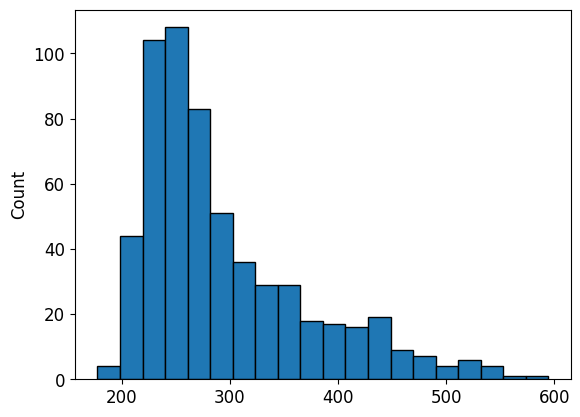

In [50]:
# MSE Histogram of Magnetomter with Resampling Rate of 60*2 = 120

print(len(mag_total_interval_vals[1]))
print(mag_total_interval_vals[1])
plt.hist(mag_total_interval_vals[1], bins = 20, edgecolor="black")
plt.ylabel("Count")
plt.show()

[[ 2.32653854  1.91854451 -0.11409077 ...  1.20101948 -0.81481248
  -1.69606577]
 [ 2.32653854  1.91809585 -0.1142879  ...  1.23715838 -0.69866243
  -1.58161836]
 [ 2.32653854  1.91833165 -0.113145   ...  1.1560794  -0.76739234
  -1.66246302]
 ...
 [ 2.32653854  1.91778621 -0.11270445 ...  1.12377871 -0.65876652
  -1.56491559]
 [ 2.32653854  1.91742257 -0.11340986 ...  1.17134632 -0.57158733
  -1.47235226]
 [ 2.32653854  1.91718935 -0.11393949 ...  1.20026762 -0.51880209
  -1.41579985]]


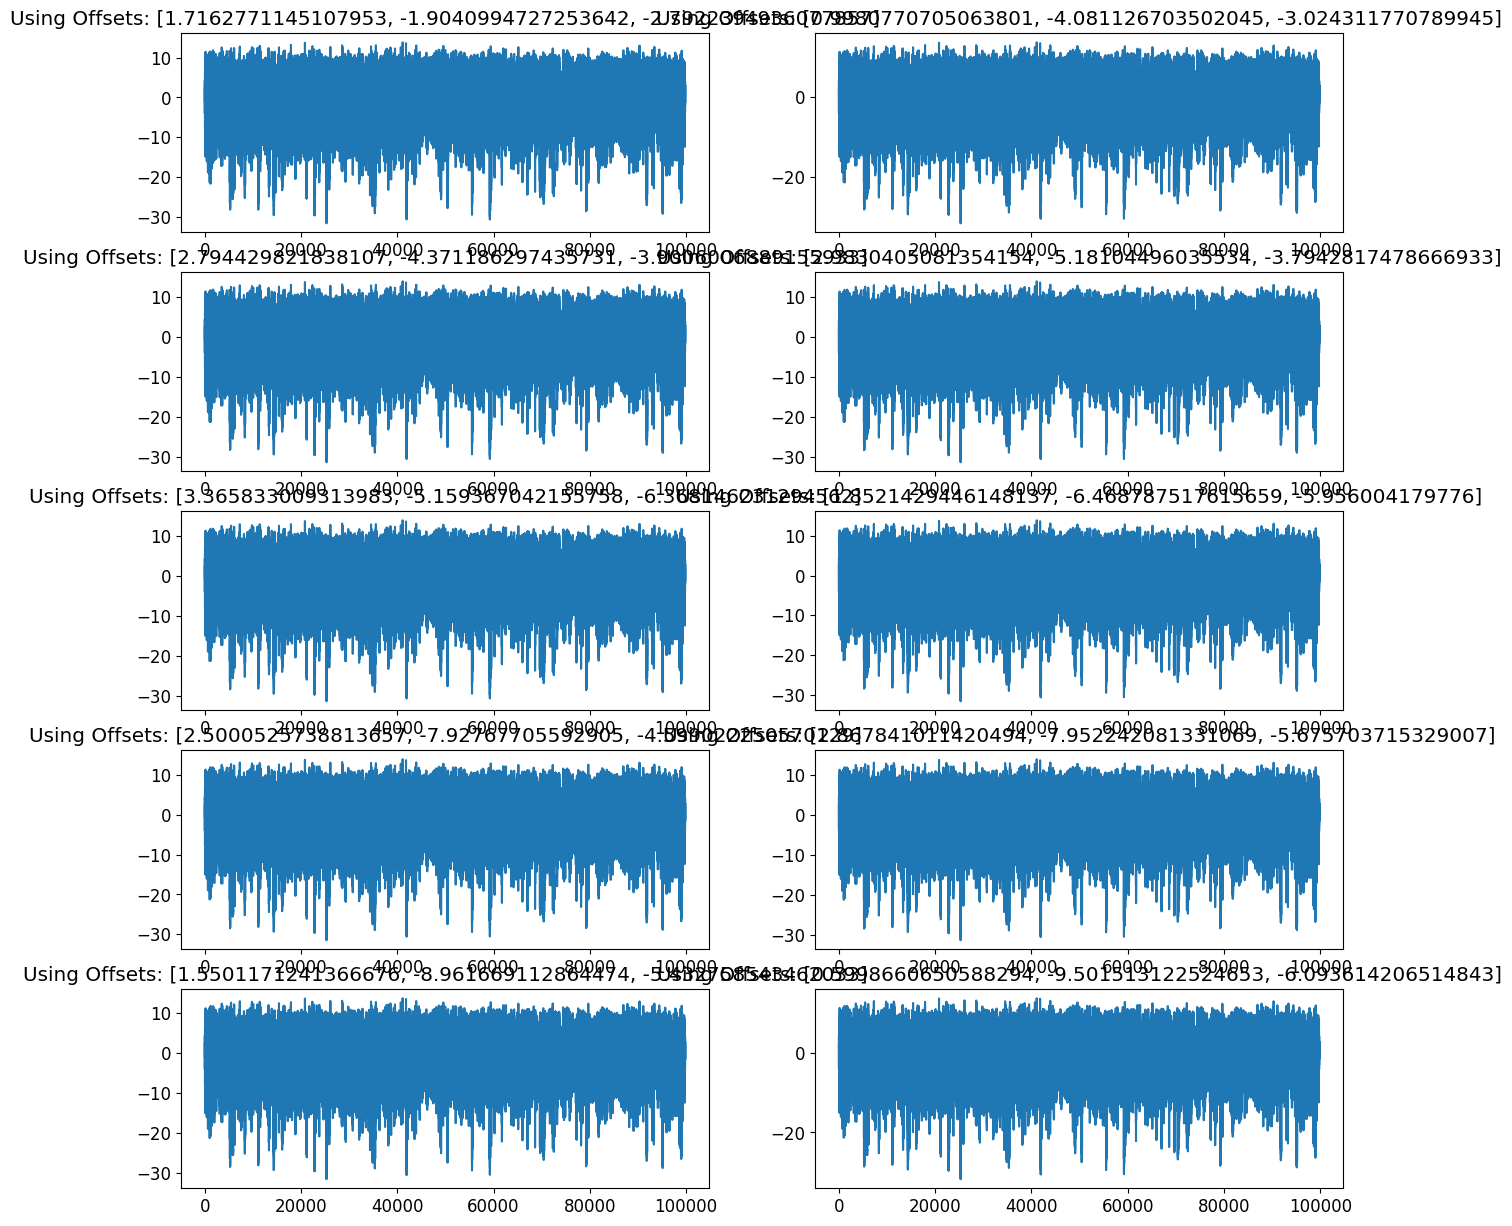

0        2.326539
1        2.122542
2        1.376997
3        0.337858
4       -0.536301
           ...   
99795   -2.469783
99796   -2.474188
99797   -2.478930
99798   -2.475733
99799   -2.469369
Length: 99800, dtype: float64
-1.9208354722537544
0        2.326539
1        2.122317
2        1.376782
3        0.337323
4       -0.537033
           ...   
99795   -2.467244
99796   -2.471876
99797   -2.476653
99798   -2.473331
99799   -2.466920
Length: 99800, dtype: float64
-1.9185674693219292
0        2.326539
1        2.122435
2        1.377242
3        0.338496
4       -0.535237
           ...   
99795   -2.452343
99796   -2.456986
99797   -2.461858
99798   -2.458443
99799   -2.451947
Length: 99800, dtype: float64
-1.9168312091090025
0        2.326539
1        2.122387
2        1.377278
3        0.338595
4       -0.535056
           ...   
99795   -2.448837
99796   -2.453559
99797   -2.458465
99798   -2.454986
99799   -2.448457
Length: 99800, dtype: float64
-1.9166534111940547
0       

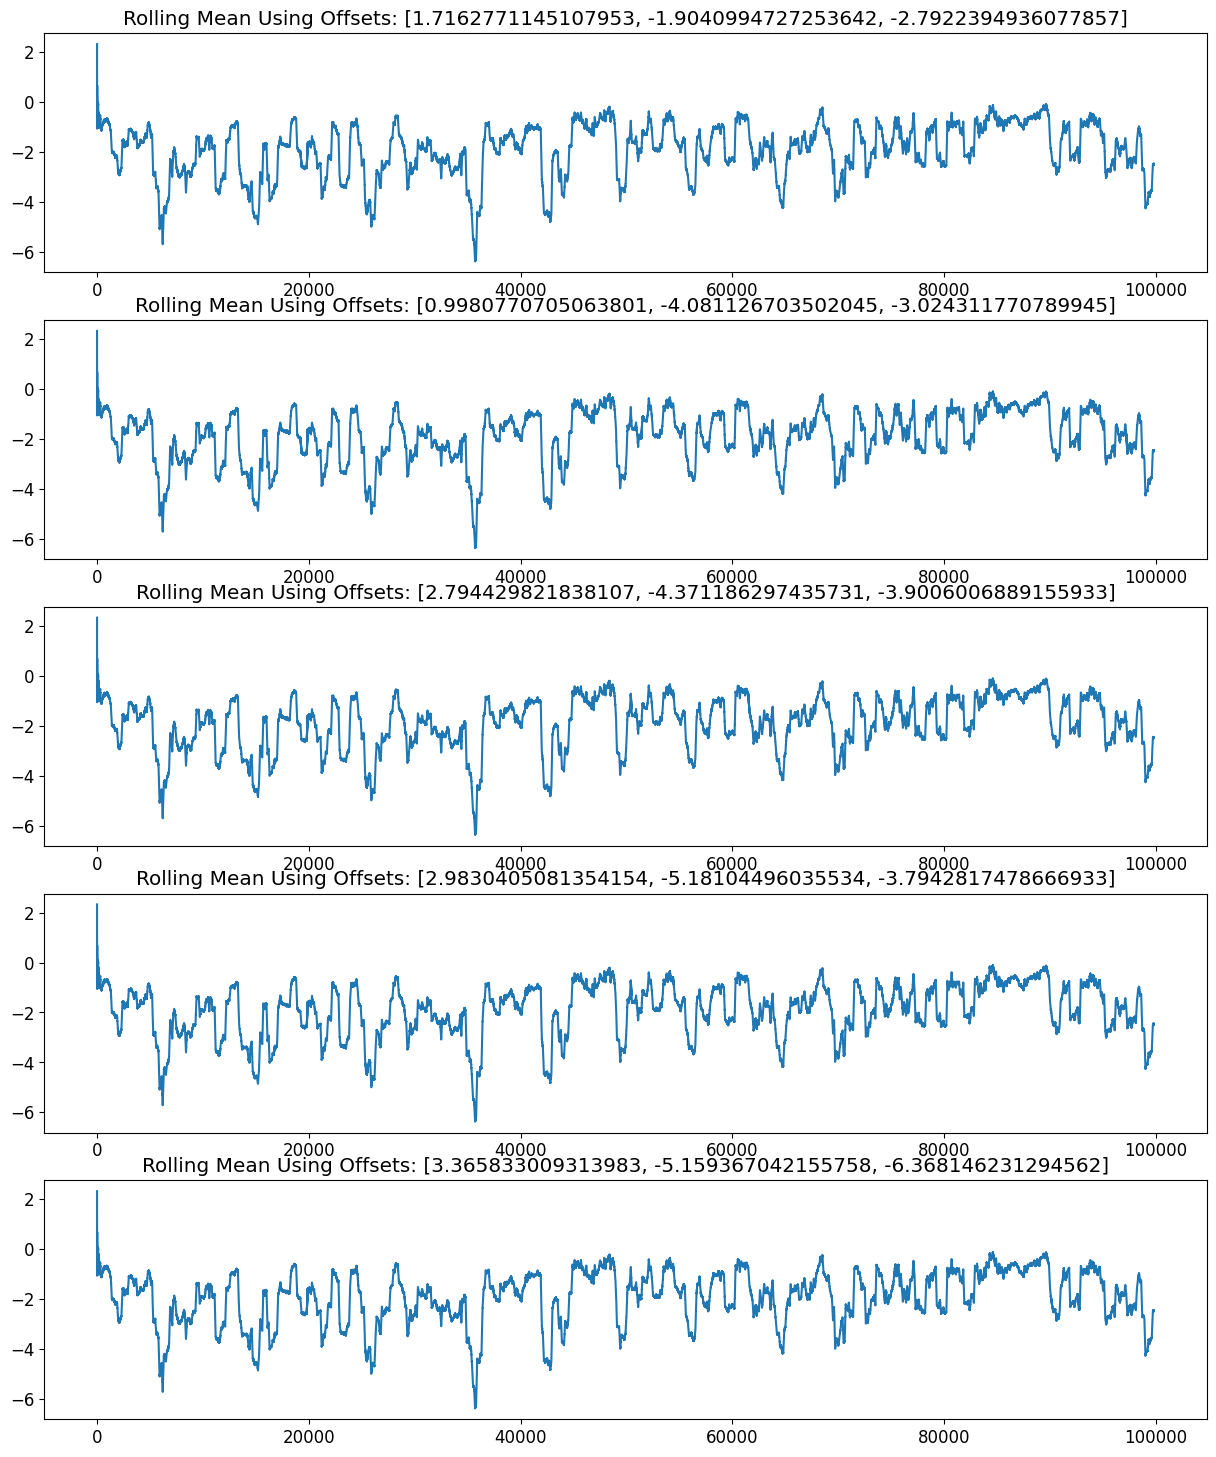

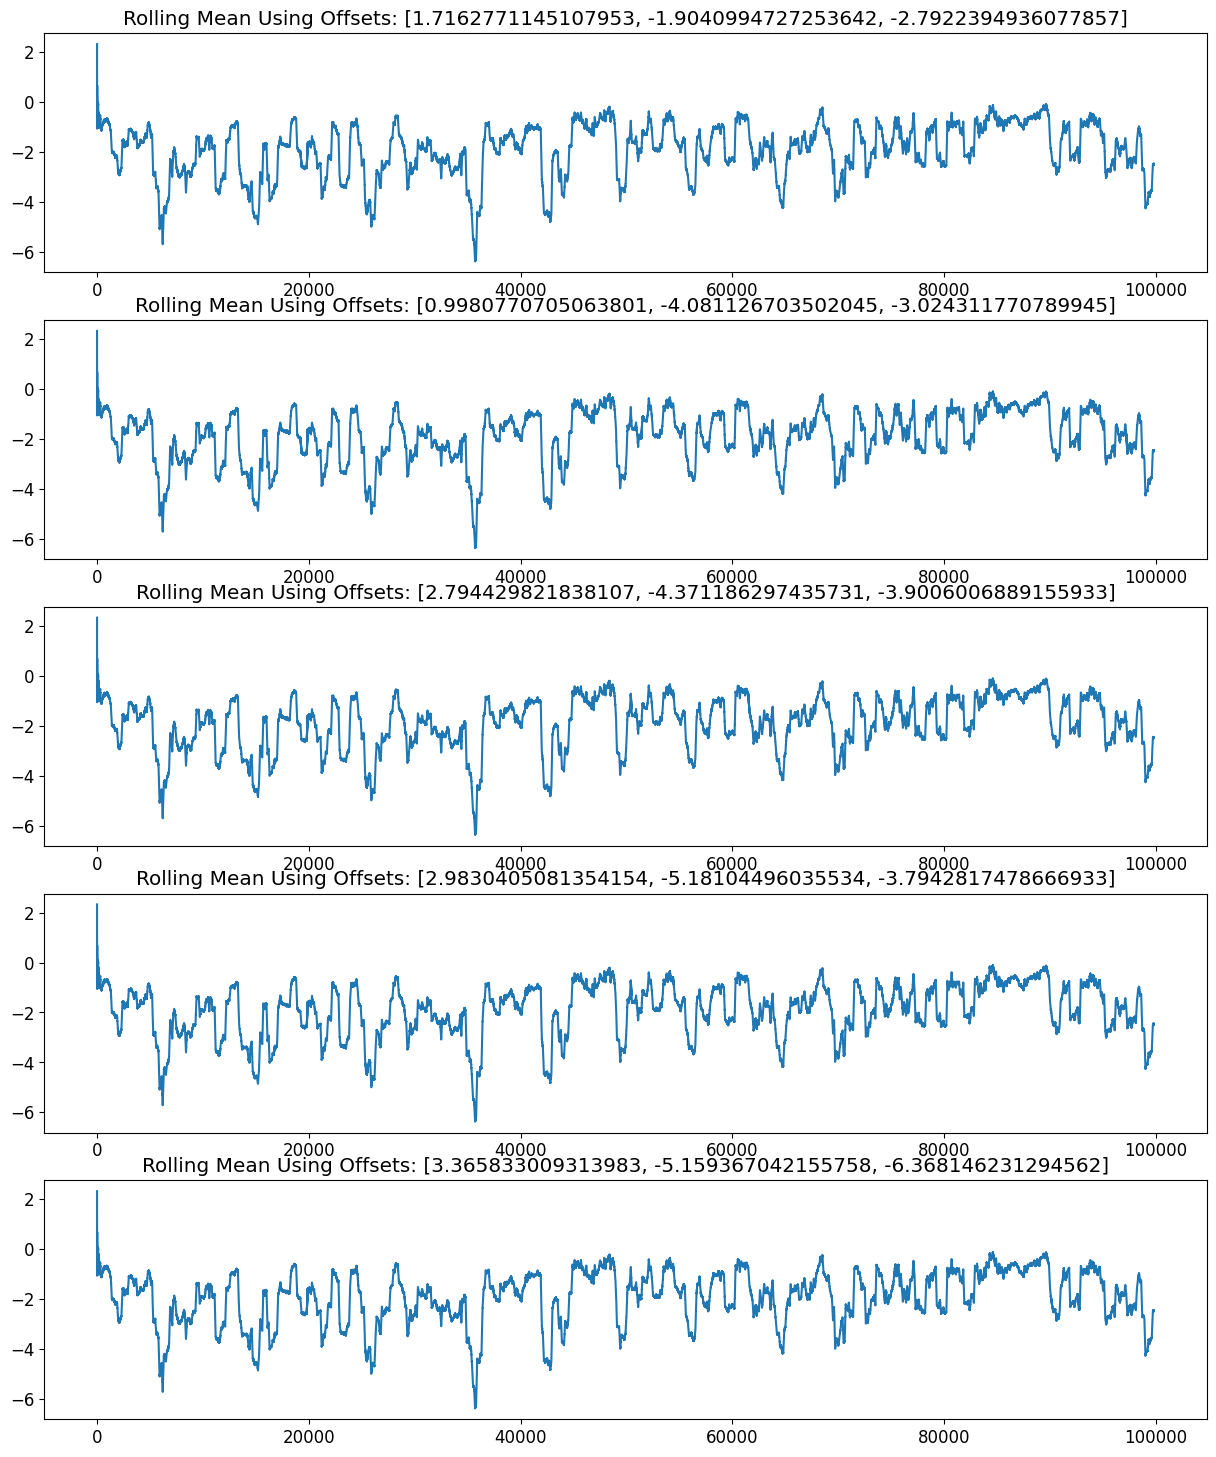

In [51]:
# Visualizing Gyr Offset Effects

interval_odr = 100
init_offset = [.58, .42, -.3]
ned_lists = []

offset_list = []

for _ in range(10):
    gyr_offsets = [np.random.normal(init_offset[i], 1) for i in range(3)]
    xl_global = []
    prev_q = [1,0,0,0]

    xl_w = [] #(3, n, 3) => window size 3, n points, xyz axis
    gy_w = []
    mg_w = []

    for (name1, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):

        xl_ = correct_data(xl_grp.drop(columns=['interval']).values)
        mg_ = correct_data(mg_grp.drop(columns=['interval']).values)
        gy_ = correct_data(gy_grp.drop(columns=['interval']).values)
        xl_p, mg_p, gy_p = preprocess_imu(xl_[:,1:], mg_[:,1:], gy_[:,1:], gyr_offset = gyr_offsets)

        xl_w.append(xl_p)
        mg_w.append(mg_p)
        gy_w.append(gy_p)

        if len(xl_w) > 3: #build window  
            xl_w.pop(0)
            mg_w.pop(0)
            gy_w.pop(0)
    
        if len(xl_w) != 3:
            continue 

        new_xl_w = [] # to unpack all 3 intervals for the window
        new_mg_w = []
        new_gy_w = []
        len_w = []
        len_mg_w = []
        len_gy_w = []

        for j, itvl in enumerate(xl_w):
            new_xl_w.append(itvl)
            len_w.append(len(itvl)) 
        for k, itvl in enumerate(mg_w):
            new_mg_w.append(itvl)
            len_mg_w.append(len(itvl))
        for l, itvl in enumerate(gy_w):
            new_gy_w.append(itvl)
            len_gy_w.append(len(itvl))

        new_xl_w = np.vstack(new_xl_w)
        new_mg_w = np.vstack(new_mg_w)
        new_gy_w = np.vstack(new_gy_w)

        xl_t = time_align(xl_w, 1000, interval_odr, 'xl')
        mg_t = time_align(mg_w, 20, interval_odr, 'mg')
        gy_t = time_align(gy_w, 1000, interval_odr, 'gy')

        # xl_t = resample(new_xl_w, num = 6000, axis = 0)
        # xl_t = decimate(xl_t, q = 2, axis = 0)

        # mg_t = resample(new_mg_w, num = 120, axis = 0)
        # mg_t = decimate(mg_t, q = 2, axis = 0)

        # gy_t = resample(new_gy_w, num = 6000, axis = 0)
        # gy_t = decimate(gy_t, q = 2, axis = 0)

        #Madgwick model gives quaternion vectors that rotate xl vector from sensor to ned frame
        model = Madgwick(acc=xl_t, mag=mg_t, gyr=gy_t, frequency=interval_odr, q0 = prev_q)
        prev_q = model.Q[-1]

        for q,x in zip(model.Q, xl_t):
            mag = np.linalg.norm(x)
            norm_vec = x / mag
            ned_vec = rotate_to_ned(q, norm_vec, madg = True)
            ned_vec *= mag
            ned_vec[2] -= 9.810665 #in ned frame, assume z axis aligns with gravity, subtract it off
            xl_global.append(ned_vec)

    xl_global = np.array(xl_global)

    offset_list.append(gyr_offsets)

    init_offset = gyr_offsets
    ned_lists.append(xl_global[:,-1])

print(np.array(ned_lists))
    
fig, axes = plt.subplots(5, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
row_count = 0
for i in range(0, 9, 2):
    axes[row_count, 0].plot(ned_lists[i])
    axes[row_count, 0].set_title("Using Offsets: " + str(offset_list[i]))
    axes[row_count, 1].plot(ned_lists[i+1])
    axes[row_count, 1].set_title("Using Offsets: " + str(offset_list[i+1]))
    row_count += 1
plt.show()

fig, axes = plt.subplots(5, 1)
fig.set_figheight(18)
fig.set_figwidth(15)
averages = []
for j in range(5):
    rolling_mean = pd.Series(ned_lists[j]).rolling(window = 1000, min_periods = 1).mean()
    print(rolling_mean)
    axes[j].plot(rolling_mean)
    axes[j].set_title("Rolling Mean Using Offsets: " + str(offset_list[j]))
    print(np.average(rolling_mean))
    averages.append(np.average(rolling_mean))

fig, axes = plt.subplots(5, 1)
fig.set_figheight(18)
fig.set_figwidth(15)
for k in range(5):
    rolling_mean = pd.Series(ned_lists[k]).rolling(window = 1000, min_periods = 1).mean()
    print(rolling_mean)
    axes[k].plot(rolling_mean)
    axes[k].set_title("Rolling Mean Using Offsets: " + str(offset_list[k]))
    print(np.average(rolling_mean))
    averages.append(np.average(rolling_mean))

print("Rolling Mean Averages: " + str(averages))

plt.show()

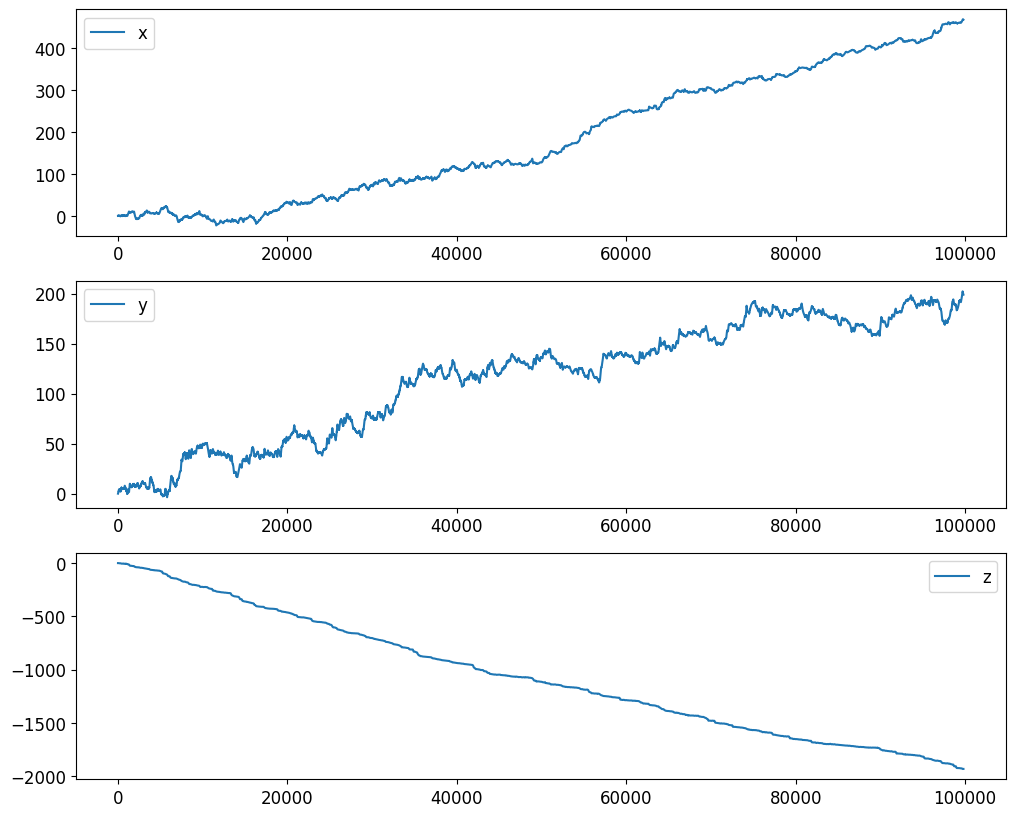

In [52]:
def imu_dead_reckoning(xl_ned, dt):
    """Calculate position, velocity and bearing from xl/mag sensors in NED frame
    Args:
        xl_ned, mag_ned: sensor data in NED frame
        dt: timestamp delta
    Retuns:
        position, velocity, bearing 
    """
    velocity = np.zeros((len(xl_ned), 3))
    position = np.zeros((len(xl_ned), 3))

    for t in range(1, len(xl_ned)):
        velocity[t] = velocity[t-1] + (xl_ned[t-1] * dt)
        position[t] = position[t-1] + (velocity[t] * dt)
    
    fig, axes = plt.subplots(3, figsize=(12,10))
    axes[0].plot(velocity[:,0], label='x')
    axes[1].plot(velocity[:,1], label='y')
    axes[2].plot(velocity[:,2], label='z')

    for ax in axes:
        ax.legend()

    plt.show()

    return position, velocity

xl_ned_pos, xl_ned_vel = imu_dead_reckoning(xl_ned, 1/100) #dt is set to 1/100, I downsampled to 100 points per second 

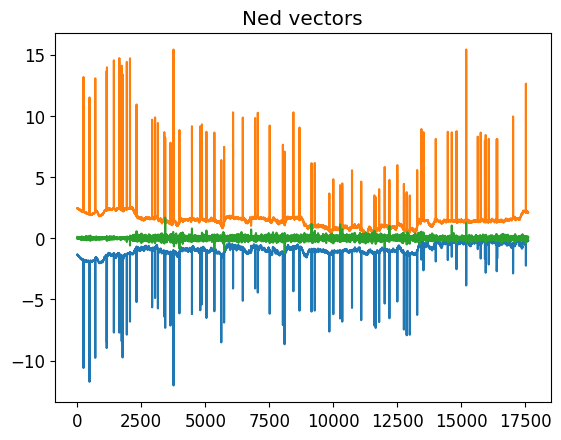

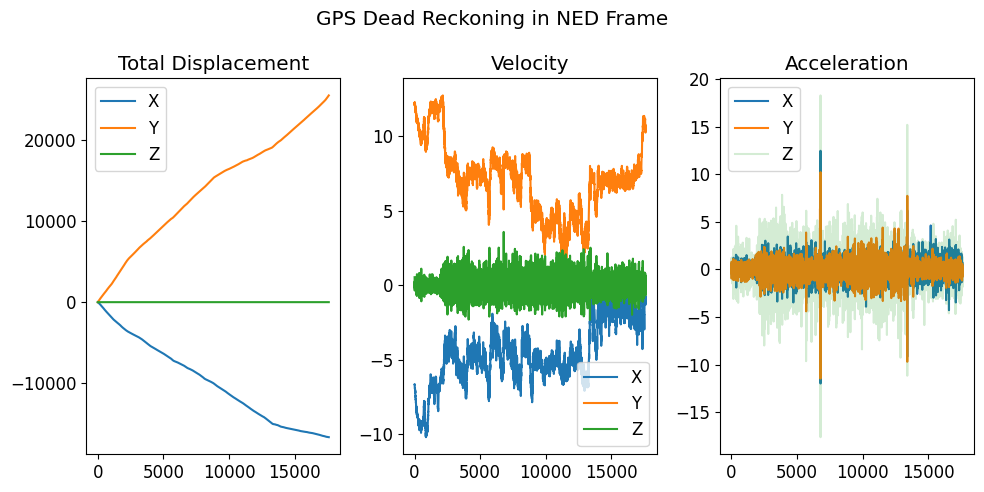

In [53]:
gps_gf = np.load("gps_data.npy")
gps_df = pd.DataFrame(gps_gf[1:,:], columns=gps_gf[0,:])
cols_to_convert = gps_df.columns[gps_df.columns != 'interval_id']
gps_df[cols_to_convert] = gps_df[cols_to_convert].apply(pd.to_numeric, errors='coerce') 

def rotation_ned(lat, lon):
    R_ned = np.array([[-np.sin(lat)*np.cos(lon), -np.sin(lat)*np.sin(lon), np.cos(lat)],
                     [-np.sin(lon), np.cos(lon),0],
                     [-np.cos(lat)*np.cos(lon), -np.cos(lat)*np.sin(lon), -np.sin(lat)]])
    return R_ned 
    
def ecef_to_ned(gps_pos_ref):
    deltas = (gps_pos_ref[['Node[1].ECEF.X', 'Node[1].ECEF.Y', 'Node[1].ECEF.Z']].values /1000) - (gps_pos_ref[['Node[1].ECEF.X.ref', 'Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref']].values/1000)   
    
    #use reference lat and lon points 
    lons = gps_pos_ref['Node[1].LLH.Lon.ref'] * (np.pi/180) 
    lats = gps_pos_ref['Node[1].LLH.Lat.ref'] * (np.pi/180)

    ned_values = []
    mags = []
    for i, (lat, lon) in enumerate(zip(lats, lons)): 
        rotation_matrix = rotation_ned(lat,lon)
        norm = np.linalg.norm(deltas[i,:])
        ned_vec = rotation_matrix @ deltas[i,:] / norm
        ned_mag = np.linalg.norm(ned_vec)
        mags.append(ned_mag )
        ned_values.append(ned_vec * norm)
    ned_values = np.array(ned_values)
    return ned_values, np.array(mags)

def gps_dead_reckoning(gps_ned, dt, start, end):
    
    plt.plot(gps_ned[:,0], label="x")
    plt.plot(gps_ned[:,1], label="y")
    plt.plot(gps_ned[:,2], label="z")
    plt.title("Ned vectors")
    plt.show()

    vel_ned = gps_ned / dt.values[:, np.newaxis]
    acc_ned = np.diff(vel_ned, axis=0) / dt.values[1:, np.newaxis]  

    displacement = [np.cumsum(gps_ned[:, 0], axis=0), 
                    np.cumsum(gps_ned[:, 1], axis=0),
                    np.cumsum(gps_ned[:, 2], axis=0)]
    
    fig, axes = plt.subplots(1,3, figsize=(10,5))
    axes[0].plot(np.cumsum(gps_ned[start:end, 0], axis=0), label='X')  
    axes[0].plot(np.cumsum(gps_ned[start:end, 1], axis=0), label='Y') 
    axes[0].plot(np.cumsum(gps_ned[start:end, 2], axis=0), label='Z')  
    axes[0].legend()
    axes[0].set_title("Total Displacement")

    vel_norm = np.linalg.norm(vel_ned[:,:2], axis=1)
    axes[1].plot(vel_ned[start:end, 0], label='X') 
    axes[1].plot(vel_ned[start:end, 1], label='Y')
    axes[1].plot(vel_ned[start:end, 2], label='Z')
    axes[1].legend()    
    axes[1].set_title("Velocity")

    axes[2].plot(acc_ned[start:end, 0], label='X')  
    axes[2].plot(acc_ned[start:end, 1], label='Y')  
    axes[2].plot(acc_ned[start:end, 2], label='Z', alpha=.2) 
    axes[2].legend()
    axes[2].set_title("Acceleration")
    fig.suptitle("GPS Dead Reckoning in NED Frame")
    plt.tight_layout()
    plt.show()

    return displacement, vel_ned, acc_ned

new_gps = gps_df.copy()
modified_shift = gps_df[['Node[1].ECEF.modified', 'timestamp']][1:]

new_gps[['Node[1].ECEF.X.ref','Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref','Node[1].LLH.Lat.ref','Node[1].LLH.Lon.ref','timestamp_ref']] = new_gps[["Node[1].ECEF.X", "Node[1].ECEF.Y","Node[1].ECEF.Z",'Node[1].LLH.Lat','Node[1].LLH.Lon', 'timestamp']].shift(1)

gps_pos_ref = new_gps[["Node[1].ECEF.X", "Node[1].ECEF.Y","Node[1].ECEF.Z",'Node[1].ECEF.X.ref','Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref',
                      'Node[1].LLH.Lat.ref', 'Node[1].LLH.Lon.ref','timestamp','timestamp_ref','interval_id']].dropna()

gps_ned, ned_mags = ecef_to_ned(gps_pos_ref)

dt = gps_pos_ref['timestamp'] - gps_pos_ref['timestamp_ref']
pos_gps , vel_gps, acc_ned = gps_dead_reckoning(gps_ned, dt, start=0, end=-1)

In [54]:
print(np.array(pos_gps).shape)

(3, 17609)


0.1275801729185443
0.1275801729185443
PCA for the raw xl1 Dataset


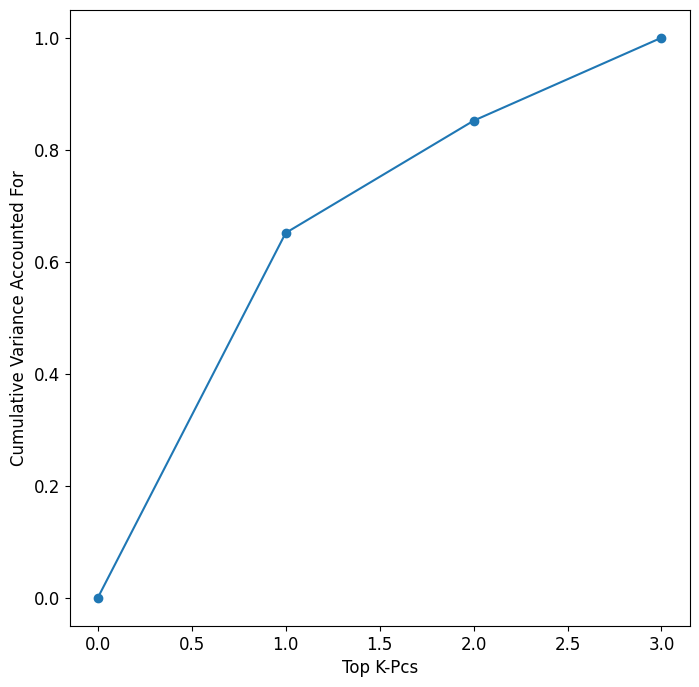

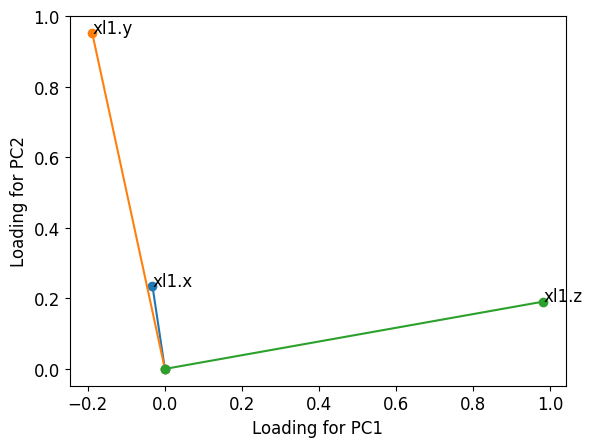

0.22885135489765626
0.22885135489765626
PCA for the Gyroscope Dataset


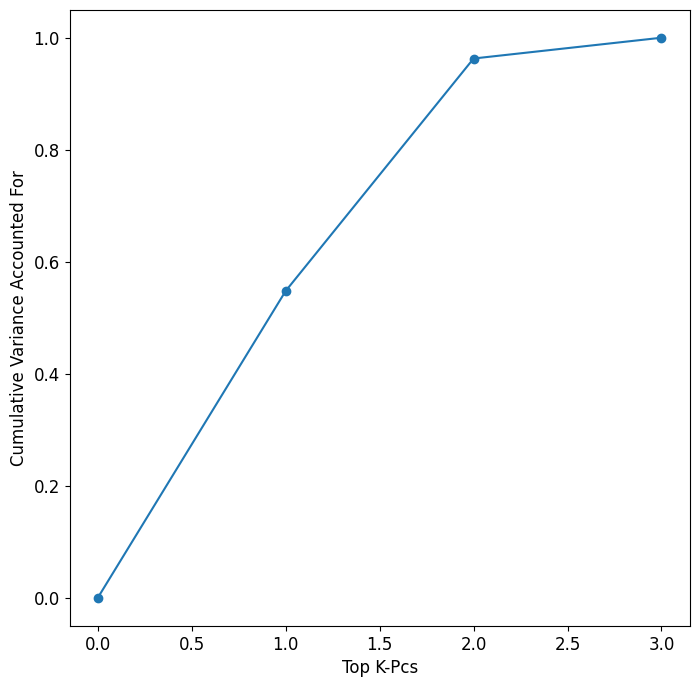

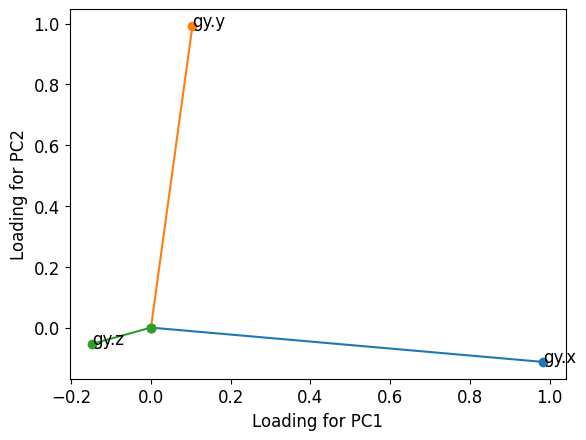

        timestamp                           interval_id  Node[1].LLH.Lat  \
0      46757787.0  19a20625-a974-468e-9487-2400b055d571        32.756010   
1      46757787.2  19a20625-a974-468e-9487-2400b055d571        32.755998   
2      46757787.4  19a20625-a974-468e-9487-2400b055d571        32.755986   
3      46757787.6  19a20625-a974-468e-9487-2400b055d571        32.755974   
4      46757787.8  19a20625-a974-468e-9487-2400b055d571        32.755962   
...           ...                                   ...              ...   
17605  46761384.0  738039cf-45a0-48ca-9966-11ca045b681d        32.605854   
17606  46761384.2  738039cf-45a0-48ca-9966-11ca045b681d        32.605853   
17607  46761384.4  738039cf-45a0-48ca-9966-11ca045b681d        32.605851   
17608  46761384.6  738039cf-45a0-48ca-9966-11ca045b681d        32.605850   
17609  46761384.8  738039cf-45a0-48ca-9966-11ca045b681d        32.605848   

       Node[1].LLH.Lon  Node[1].LLH.Height  Node[1].LLH.HeightMSL  \
0           -79.86

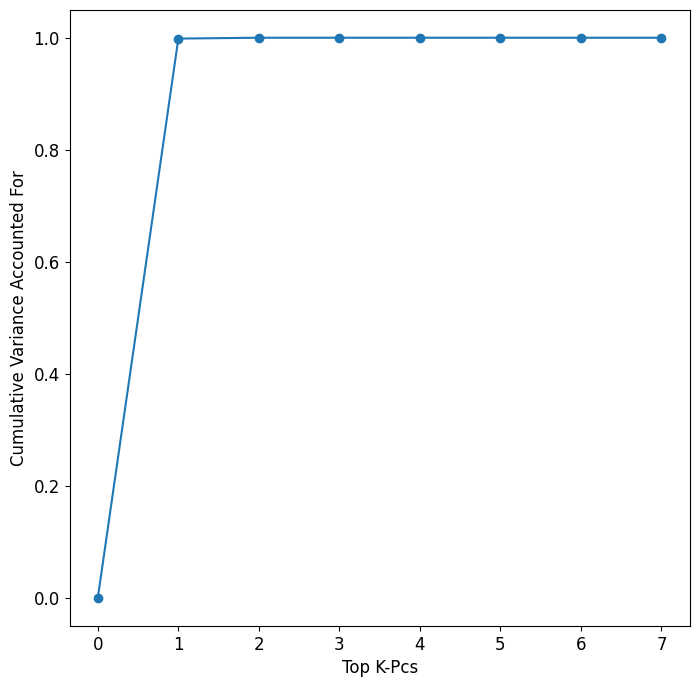

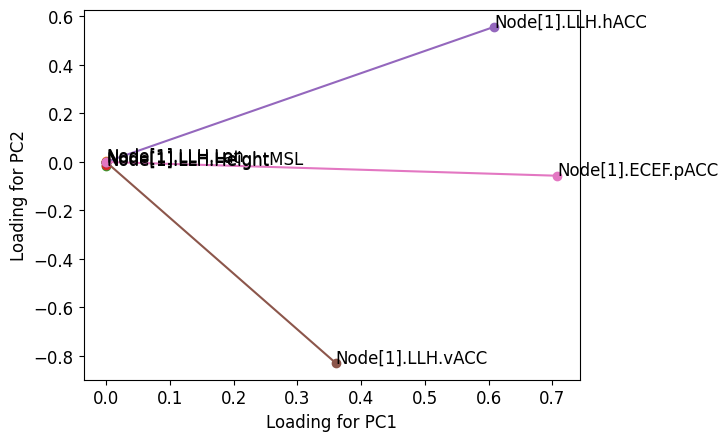

In [21]:
# Implementing PCA on xl1_ned and xl1_dat

xl_pca = pca.PCA(xl1)
xl_pca.fit(["xl1.x", "xl1.y", "xl1.z"])
xl_pca.elbow_plot()

print("PCA for the raw xl1 Dataset")

plt.subplots()
xl_pca.loading_plot()
plt.show()


gy_pca = pca.PCA(gy)
gy_pca.fit(["gy.x", "gy.y", "gy.z"])
gy_pca.elbow_plot()

print("PCA for the Gyroscope Dataset")

plt.subplots()
gy_pca.loading_plot()
plt.show()


gps_gf = np.load("gps_data.npy")
gps_df = pd.DataFrame(gps_gf[1:,:], columns=gps_gf[0,:])
cols_to_convert = gps_df.columns[gps_df.columns != 'interval_id']
gps_df[cols_to_convert] = gps_df[cols_to_convert].apply(pd.to_numeric, errors='coerce') 

gps_pca = pca.PCA(gps_df)
print(gps_df)
column_list = list(gps_df.columns)
print(column_list)
gps_first_node = column_list[2:9] + column_list[12:15]
gps_first_node = gps_first_node[:6] + [gps_first_node[7]]
print(gps_first_node)
gps_pca.fit(gps_first_node)
gps_pca.elbow_plot()

print("PCA for the GPS Dataset")

plt.subplots()
gps_pca.loading_plot()
plt.show()

(99800, 3)
(99800, 3)


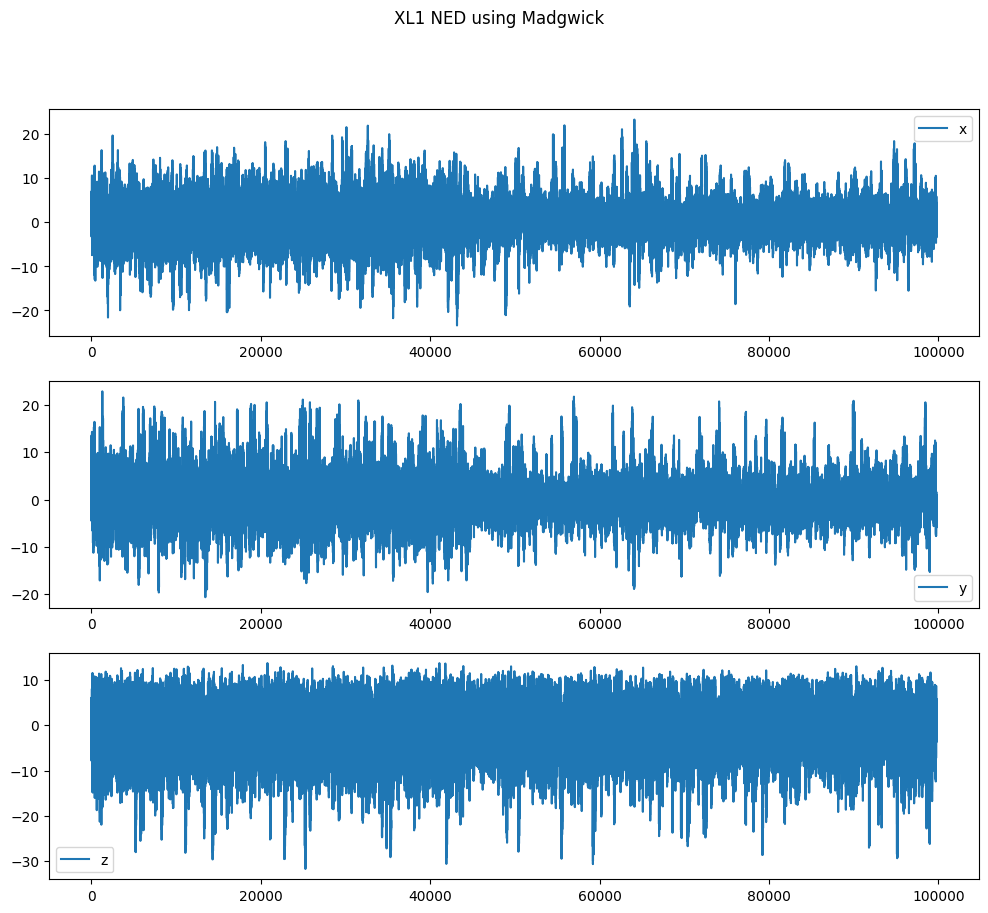

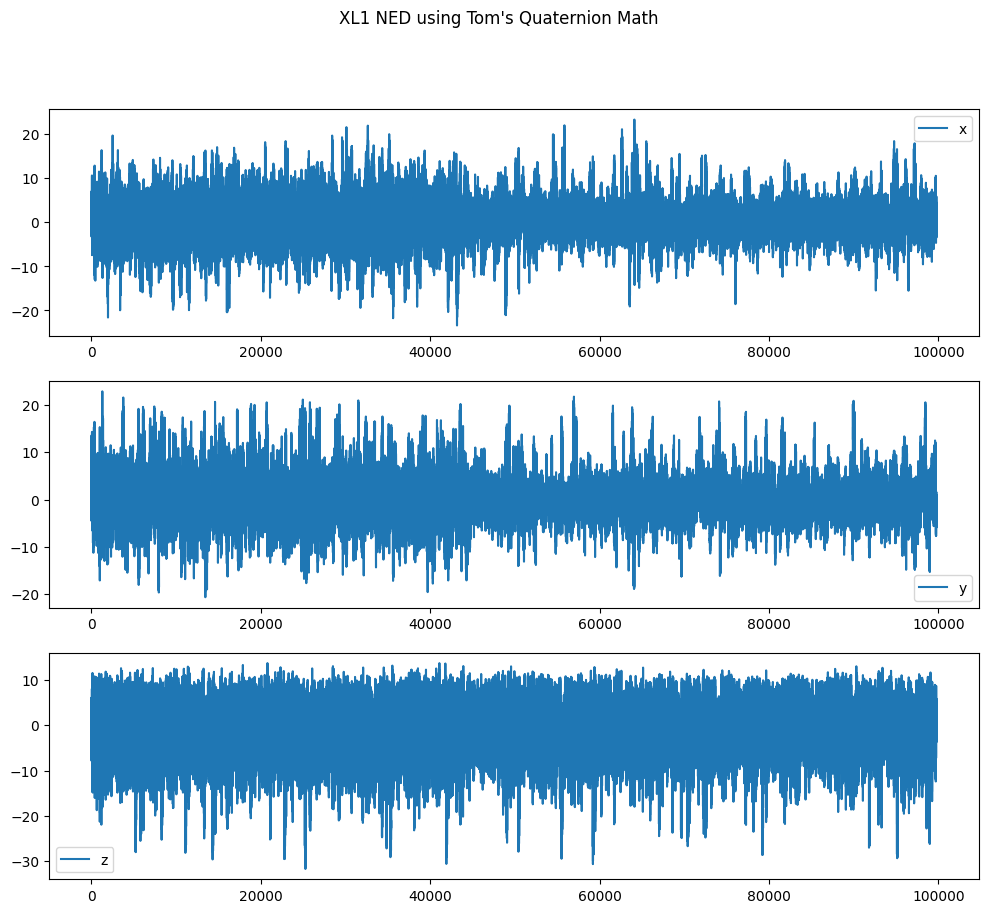

Velocity using Madgwick:


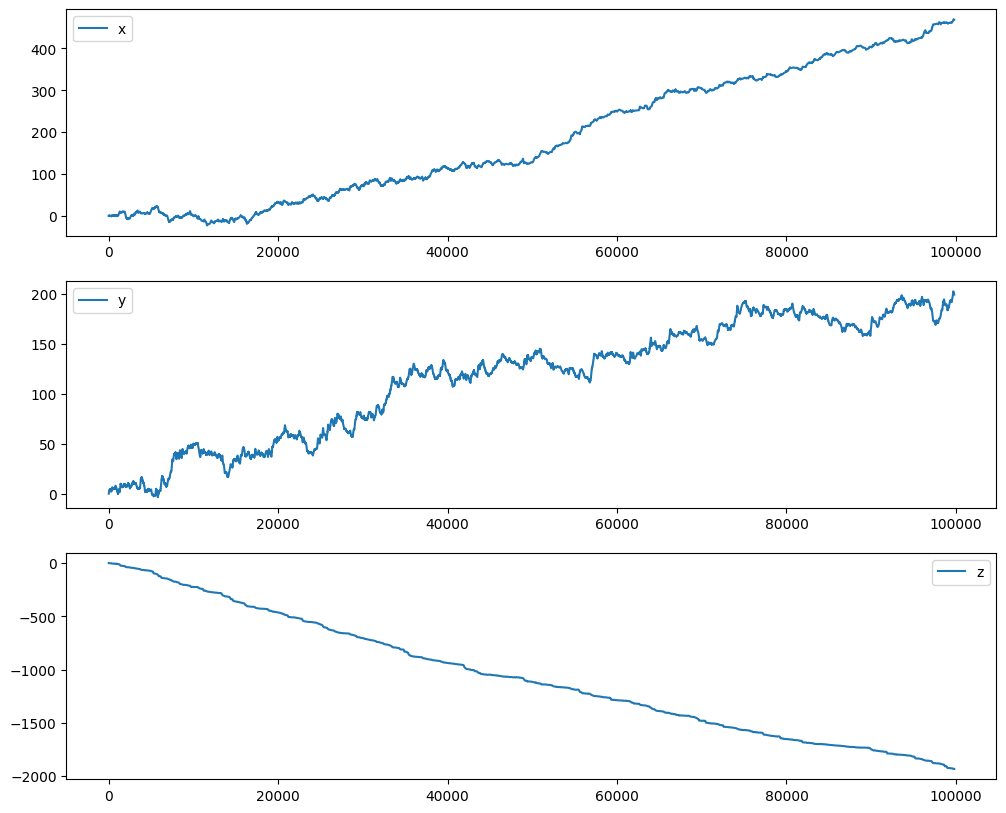

Velocity using Tom's Quaternion Math


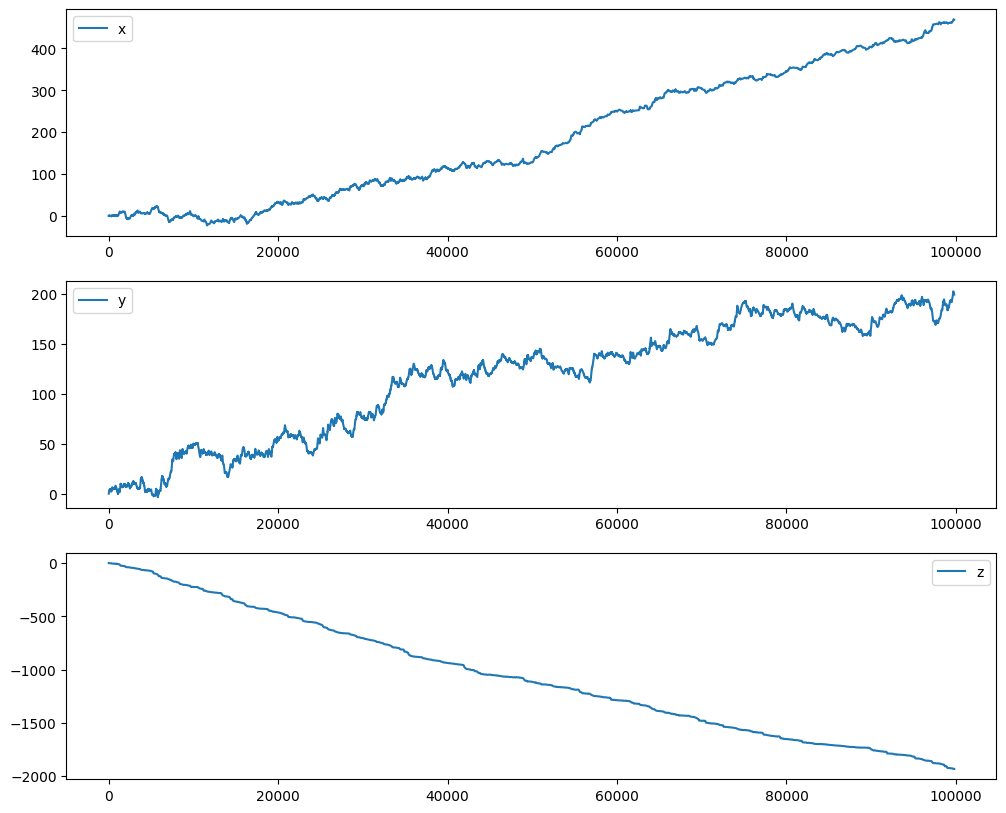

Calculating Errors:


In [16]:
# Comparing Madgwick and Quaternion Math

xl_ned_m = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100, madg = True))
print(np.array(xl_ned).shape)

xl_ned_q = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100, madg = False))
print(np.array(xl_ned).shape)

xl_ned_q_test = np.round(xl_ned_q, decimals = 3).tolist()
xl_ned_m_test = np.round(xl_ned_m, decimals = 3).tolist()

assert xl_ned_q_test == xl_ned_m_test, "Fail"

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned_m[:,0], label='x')
axes[1].plot(xl_ned_m[:,1], label='y')
axes[2].plot(xl_ned_m[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 NED using Madgwick')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned_q[:,0], label='x')
axes[1].plot(xl_ned_q[:,1], label='y')
axes[2].plot(xl_ned_q[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle("XL1 NED using Tom's Quaternion Math")
plt.show()


print("Velocity using Madgwick:")
imu_dead_reckoning(xl_ned_m, 1/100)

print("Velocity using Tom's Quaternion Math")
imu_dead_reckoning(xl_ned_q, 1/100)

print("Calculating Errors:")

(930064, 5)
(18427, 5)
(933740, 5)


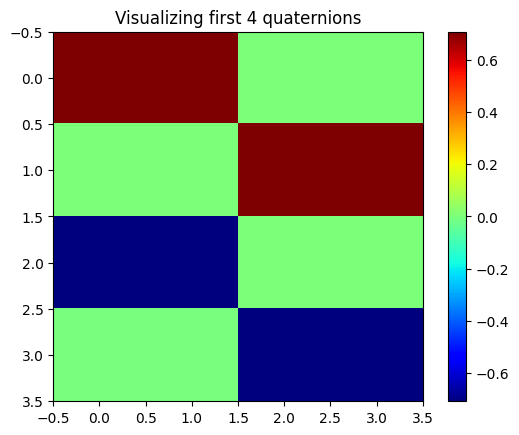

In [19]:
# Visualizing first 4 quaternions using raw data
# I repeated the Madgwick operation to generate a heatmap using the first four vectors.
# This result will be compared using the time aligned and processed imu data for comparison.

print(xl_dat.shape)
print(mg_dat.shape)
print(gy_dat.shape)
new_xl = xl_dat[:18427,:3]
new_gy = gy_dat[:18427,:3]

new_quaternions = Madgwick(acc = new_xl, mqt = mg_dat[:,:3], gyr=new_gy)
quart_array = []
for q,x in zip(new_quaternions.Q, new_xl):
        mag = np.linalg.norm(x)
        norm_vec = x / mag
        ned_vec = rotate_to_ned(q, norm_vec, madg = True)
        ned_vec = ned_vec*mag
        quart_array.append(q)

new_quart_array = np.array(quart_array)
new_quart_array = new_quart_array[:4,:]
plt.imshow(new_quart_array, cmap="jet")
plt.colorbar()
plt.title("Visualizing first 4 quaternions")
plt.show()


In [20]:
print(ned_vec)
print(ned_vec.shape)

[-7.33995451e+06  2.43923388e+01 -4.61781059e+07]
(3,)


Text(0.5, 1.0, 'Resampling 32 data points of the sin function')

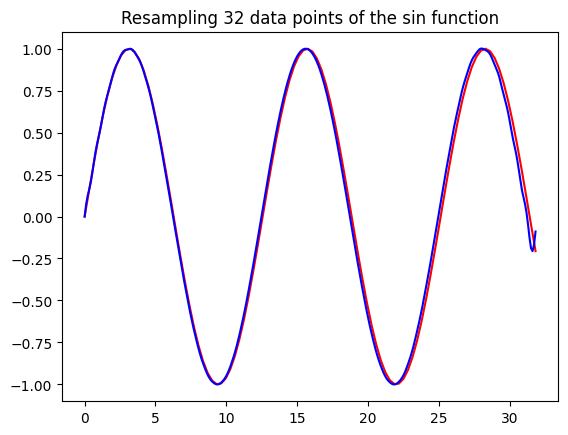

In [21]:
# Visualizing the effects of resampling

test_interval = 100
sample_x_vals = np.linspace(0, (100/np.pi), 100)
sample_y_vals = np.sin((sample_x_vals/2))

data_r = resample(sample_y_vals, test_interval*3)
sample_x_r_vals = np.linspace(0, (100/np.pi), 300)

plt.plot(sample_x_vals, sample_y_vals, 'r')
plt.plot(sample_x_r_vals, data_r, 'b')

plt.title("Resampling 32 data points of the sin function")


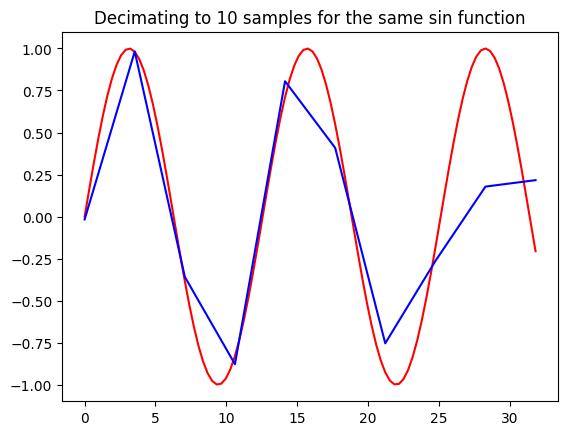

In [22]:
# Visualizing the effects of decimating

data_d = decimate(data_r, q=test_interval//3, axis=0)

plt.plot(sample_x_vals, sample_y_vals, 'r')
plt.plot(np.linspace(0,(100/np.pi),10), data_d, 'b')

plt.title("Decimating to 10 samples for the same sin function")
plt.show()

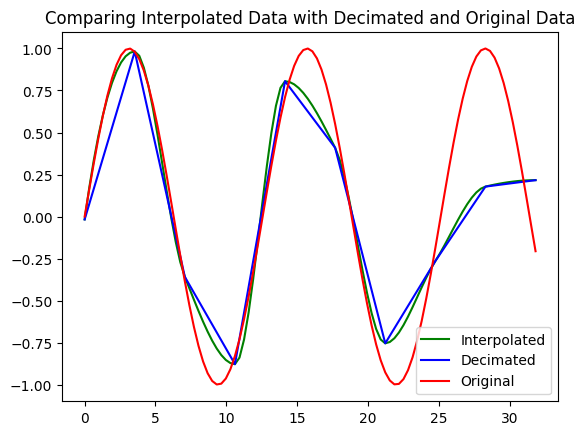

In [23]:
# Interpolating on the decimated sample data, i.e data_d
spline = PchipInterpolator(np.linspace(0,(100/np.pi),10), data_d)
interp_data = spline(np.linspace(0,(100/np.pi),100))

plt.plot(np.linspace(0,(100/np.pi),100), interp_data, 'g', label="Interpolated")
plt.plot(np.linspace(0,(100/np.pi),10), data_d, 'b', label="Decimated")
plt.plot(sample_x_vals, sample_y_vals, 'r', label="Original")

plt.title("Comparing Interpolated Data with Decimated and Original Data")
plt.legend()
plt.show()



In [24]:
# Storing the imu data inside a custom data class

import data

imu_data = data.Data("modified_xl1.csv")
print(imu_data)


 -------------------------------
modified_xl1.csv (930064x5)
Headers: 
  interval    timestamp    xl1.x    xl1.y    xl1.z  
Showing first 5/930064 rows.
0.0     46757786.0008     -0.39365234375     -0.60496875     1.1908125     
0.0     46757786.0018     0.27239453125     0.32833984375     0.9079453125     
0.0     46757786.0028     0.5186640625     0.7189375     1.0464765625     
0.0     46757786.0038     0.5548671875     0.10870703125     1.96628125     
0.0     46757786.0048     0.09496484375     0.002421875     0.63576953125     



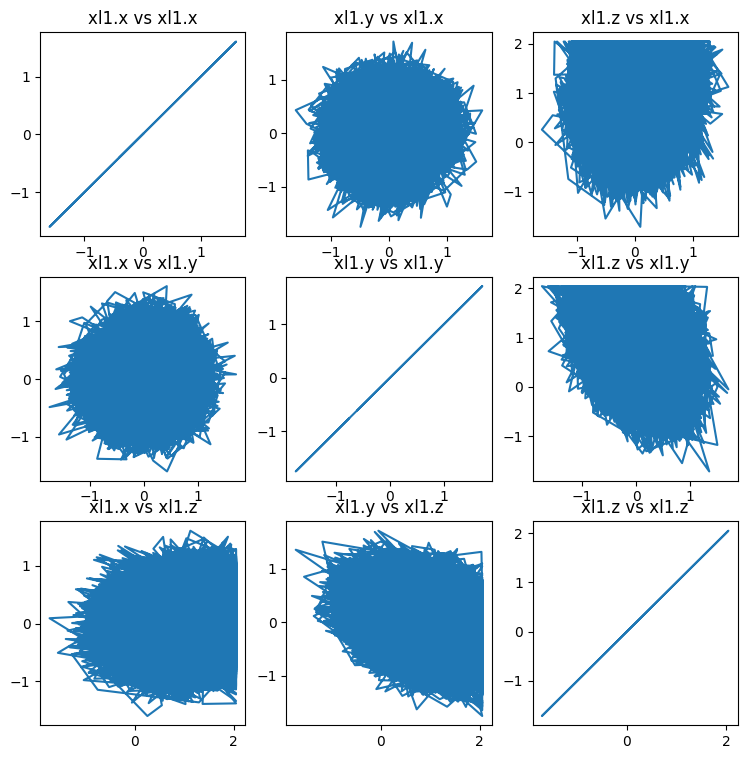

In [25]:
header_list = ["xl1.x", "xl1.y", "xl1.z"]
imu_copy = imu_data.select_data(headers = header_list, rows = list(np.arange(0, 200000, 1)))
fig, axes = plt.subplots(3,3)
fig.set_figheight(9)
fig.set_figwidth(9)

for i in range(3):
    for j in range(3):
        axes[i][j].plot(imu_copy[:,i], imu_copy[:,j])
        axes[i][j].set_title(header_list[j] + " vs " + header_list[i])
